In [1]:
library(here)
library(glue)
library(tidyverse)
library(broom)
library(ggrepel)
library(latex2exp)
library(cowplot)
library(Metrics)
library(bdkn)

here() starts at /mnt/expressions/mp/nea-over-time
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.7
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse() masks glue::collapse()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%



In [2]:
walk(list.files(here("figures"), ".png", full.names = TRUE), unlink)

<br><br><br><br><br>
# Figure 2

### SLiM trajectory average

In [3]:
mutations <- readRDS(here("data/rds/mutations.rds"))

mutation_traj <- mutations %>%
  filter(mut_type %in% c("gap_marker", "region_marker")) %>% 
  group_by(gen, rep, mut_type) %>%
  summarise(avg_nea=mean(freq)) %>%
  group_by(gen, mut_type) %>%
  summarise(mean_rep=mean(avg_nea), sd_rep=sd(avg_nea), n_rep=n()) %>%
  mutate(se_rep=sd_rep / sqrt(n_rep),
         lower_ci=mean_rep - qnorm(1 - (0.05 / 2)) * se_rep,
         upper_ci=mean_rep + qnorm(1 - (0.05 / 2)) * se_rep)

In [4]:
# Near East populations to exclude from the plots containing Europeans
near_east <- c("BedouinB", "Yemenite_Jew", "Palestinian", "Iraqi_Jew", "Jordanian", "Druze", "Iranian", "Samaritan")
ignore_samples <- near_east

nea_est <- readRDS(here("data/rds/nea_estimates.rds")) %>%
    filter(X %notin% ignore_samples,
           stat == "admixture_prop" | stat == "indirect_f4" | C == "Dinka",
           pop %in% c("EMH", "WestEurasia"))

both_f4 <- filter(nea_est,
                 stat %in% c("indirect_f4", "direct_f4"),
                 snp_count > 200000) %>%
  mutate(gen = 2200 - age/25)

In [5]:
set_dim(5, 3.5, 300)

p1 <- ggplot(mutation_traj, aes(gen, mean_rep)) +
  geom_line(size = 0.5, aes(color=mut_type, group = mut_type)) +
  geom_ribbon(aes(ymin=lower_ci, ymax=upper_ci, color=mut_type, group = mut_type, fill = mut_type), color = NA, alpha=1/2) +
  xlab("generation after admixture") + ylab("Neandertal ancestry proportion") +
  coord_cartesian(y=c(0, 0.1))

p1a <- geom_smooth(data=both_f4, 
                   mapping=aes(x = gen, y = alpha, weight=snp_count, lty=stat), inherit.aes = FALSE,
              method='lm', color='black', size=.5)

p_traj <- p1 + p1a + theme_classic() +
  theme(legend.position = c(0.9, 1), legend.justification = c(0.9, 1), 
        legend.text = element_text(size=8), 
        legend.title = element_text(size=8)) +
  scale_color_manual("Simulated Neandertal ancestry",
                     values = c("red", "blue"),
                     labels = c("neutral Neandertal markers outside selected regions", 
                                "neutral Neandertal markers within selected regions")) +
  scale_fill_manual("Simulated Neandertal ancestry",
                     values = c("red", "blue"),
                     labels= c("neutral Neandertal markers outside selected regions", 
                               "neutral Neandertal markers within selected regions")) +
scale_linetype_manual("Neandertal ancestry estimates",
                   values = c(1, 3))

#p_traj

## Deltas of allele frequencies over time

In [6]:
deltas <- readRDS(here("data/rds/mutation_deltas.rds"))

In [7]:
set_dim(4, 5, 300)

p_deltas <- group_by(deltas, g, mut_type, rep) %>%    
  summarise(avg_delta=mean(delta_f), sd_delta=sd(delta_f), n_delta=n()) %>%
  mutate(se_delta=sd_delta / sqrt(n_delta),
         lower_ci=avg_delta - qnorm(1 - (0.05 / 2)) * se_delta,
         upper_ci=avg_delta + qnorm(1 - (0.05 / 2)) * se_delta) %>% 
  filter(g >= 200) %>% 
  ungroup %>% 
  filter(mut_type %in% c("gap_marker", "region_marker", "Nea_del")) %>% 
  mutate(mut_type=case_when(mut_type == "MH_del" ~ "MH deleterious",
                            mut_type == "Nea_del" ~ "deleterious",
                            mut_type == "gap_marker" ~ "neutral outside",
                            mut_type == "region_marker" ~ "neutral within")) %>% 
  mutate(mut_type = factor(mut_type, levels = c("deleterious",
                                                "neutral within",
                                                "neutral outside"))) %>% 
ggplot(aes(g, avg_delta)) +
  geom_line(aes(color=rep), linetype = 2, size = 0.25, alpha = 0.5) +
  geom_ribbon(aes(g, ymin=lower_ci, ymax=upper_ci, fill=rep), alpha=0.5) +
  geom_smooth(fill="black", color = "black", size = 0.75, se = FALSE) + 
  geom_hline(yintercept=0, linetype=2, color = "red", size = 0.5) +
  facet_grid(mut_type ~ .) + 
  xlab("generation after admixture") + ylab("mean frequency change") +
  theme_bw() +
  theme(legend.position="none")

#p_deltas

### Efficacy of negative selection vs distance to functional regions

In [8]:
bin_props <- readRDS(here("data/rds/depletion_near_genes.rds"))

In [9]:
p_bins <- bin_props %>% filter(gen >= 10) %>% 
    group_by(dist_bin, gen) %>%
    summarise(nea_prop = mean(nea_prop)) %>%
ggplot(aes(x=dist_bin, y=nea_prop, group=gen, color=as.factor(gen))) +
    geom_line() + 
    geom_point() +
    theme_classic() +
    theme(legend.position = "bottom", legend.title = element_text(size = 9),
          legend.text=element_text(size=7)) +
    xlab("distance from a region under selection (quantiles)") +
    ylab("Neandertal ancestry proportion") +
    scale_color_discrete(name = "generation")

#p_bins

### combined

In [10]:
row1_p <- plot_grid((ggdraw() + draw_image(here("figures/diagrams/slim.png"))), rel_widths = c(1, 1),
                     p_traj, labels = c("A", "B"), ncol = 2)
row2_p <- plot_grid(p_bins, p_deltas, labels = c("C", "D"), ncol = 2, rel_widths = c(1, 1))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


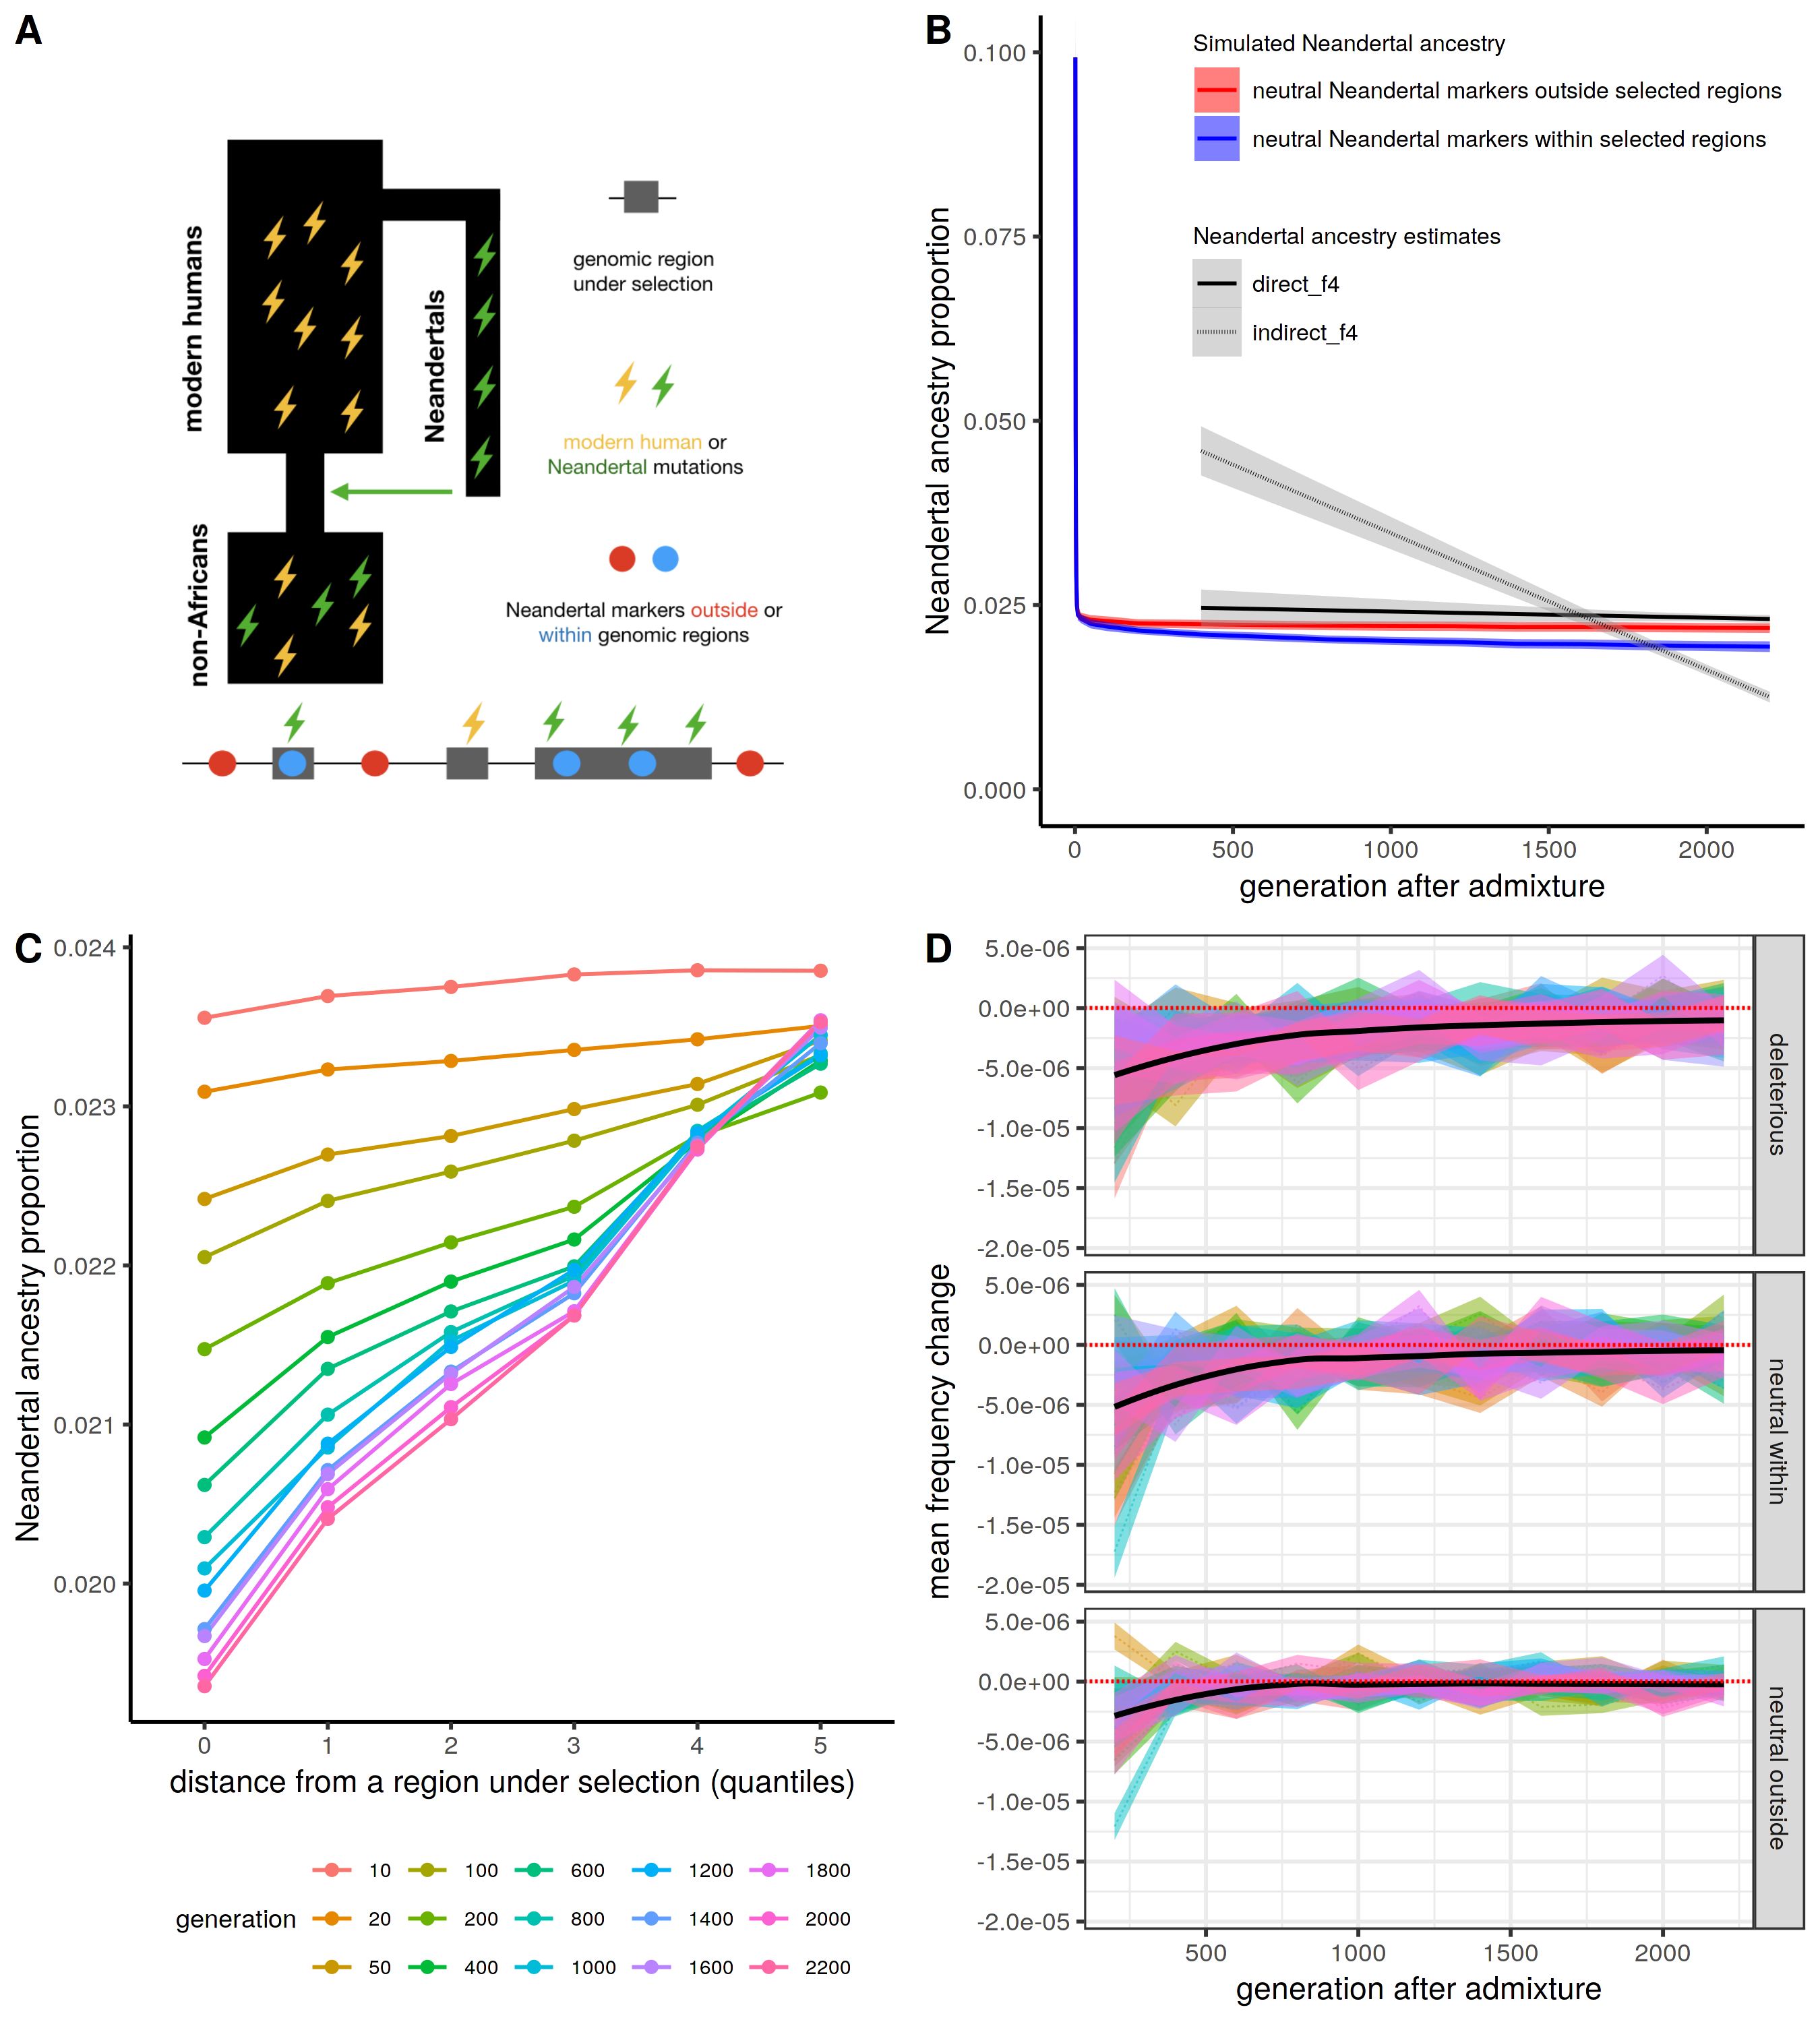

In [11]:
set_dim(9, 10, 300)
plot_grid(row1_p, row2_p, nrow = 2, rel_heights = c(1, 1.2))

ggsave(here("figures/2.png"), width = 9, height = 10, units = "in")

# Figure S2

### empirical $f_4$

In [12]:
affinity_chimp_ui <- readRDS(here("data/rds/affinity_chimp_ui.rds"))

In [13]:
set_dim(7, 3.5, 300)

f4_real <- filter(affinity_chimp_ui, nsnps > 200000) %>%
group_by(target_pop, X, age) %>%
summarise(f4 = mean(f4), Zscore = mean(Zscore), nsnps = mean(nsnps)) %>%
filter(target_pop %in% c("EastAfrica", "CentralAfrica", "WestAfrica", "SouthAfrica"), 
       X %notin% near_east) %>%
ungroup %>% 
mutate(target_pop = str_replace(target_pop, "Africa", " Africa")) %>% 
mutate(Y = paste("Y =", target_pop)) %>% 
mutate(Y = factor(Y, levels = c("Y = East Africa", "Y = Central Africa", "Y = West Africa", "Y = South Africa"))) %>%
ggplot(aes(age, f4)) +
    geom_point(aes(shape = abs(Zscore) >= 3), size = 5, alpha = 1/2) +
    geom_hline(yintercept = 0, linetype = 2, color = "red") +
    xlim(40000, -2000) + ylim(-0.004, 0.0) +
    facet_grid(. ~ Y) +
    xlab("years before present") + ylab("f4") +
    ggtitle("f4(Ust'-Ishim, X; African Y, Chimp)") +
    scale_shape_manual(name = "|Z-score|", labels = c("< 3", ">= 3"), values = c(21, 19)) +
    theme_bw() + theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### simulated $f_4$

In [14]:
read_sims <- function(t, direction) {
    files <- list.files(here("data/msprime_sims"),
                        glue("^geneflow_{t}_{direction}.*.tsv"),
                        full.names = TRUE)
    if (!length(files)) return(NULL)
    map_dfr(files,
        ~ suppressMessages(read_tsv(.x)) %>% mutate(t = t, direction = direction)
    ) %>%
    gather(stat, value, -c(name, age, t, direction))
}

times <- c(5000, 10000, 15000, 20000)
directions <- c("eur_to_afr", "afr_to_eur", "both_directions", "no_migration")

df <- map_dfr(times, function(t)
      map_dfr(directions, function(direction) read_sims(t, direction)))

trajectories <- 
    filter(df, t >= 5000) %>% 
    mutate(t = glue("gene flow at {t} years")) %>%
    mutate(t = factor(t, levels = glue("gene flow at {c(5000, 10000, 15000, 20000)} years"))) %>%
    mutate(direction = case_when(direction == "afr_to_eur" ~ "AFR -> EUR",
                                 direction == "eur_to_afr" ~ "EUR -> AFR",
                                 direction == "both_directions" ~ "AFR <-> EUR",
                                 direction == "no_migration" ~ "no gene-flow"))

In [15]:
f4_sim <- ggplot(trajectories, aes(age, value, color = direction)) +
    geom_smooth(size = 0.5) +
    geom_vline(data = select(trajectories, t) %>% mutate(x = as.integer(str_replace(t, ".* (\\d+) years", "\\1"))),
               aes(xintercept = x), linetype = 2, size =0.5, alpha = 0.5) +
    facet_grid(. ~ t) +
    xlim(55000, 0) +
    ggtitle("Simulated f4(ancient European, X; African, Chimp)") +
    ylab("f4") + xlab("years before present") +
    labs(color = "direction of gene flow") +
    theme_bw() + theme(legend.position = "bottom")

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 8000 rows containing non-finite values (stat_smooth).”

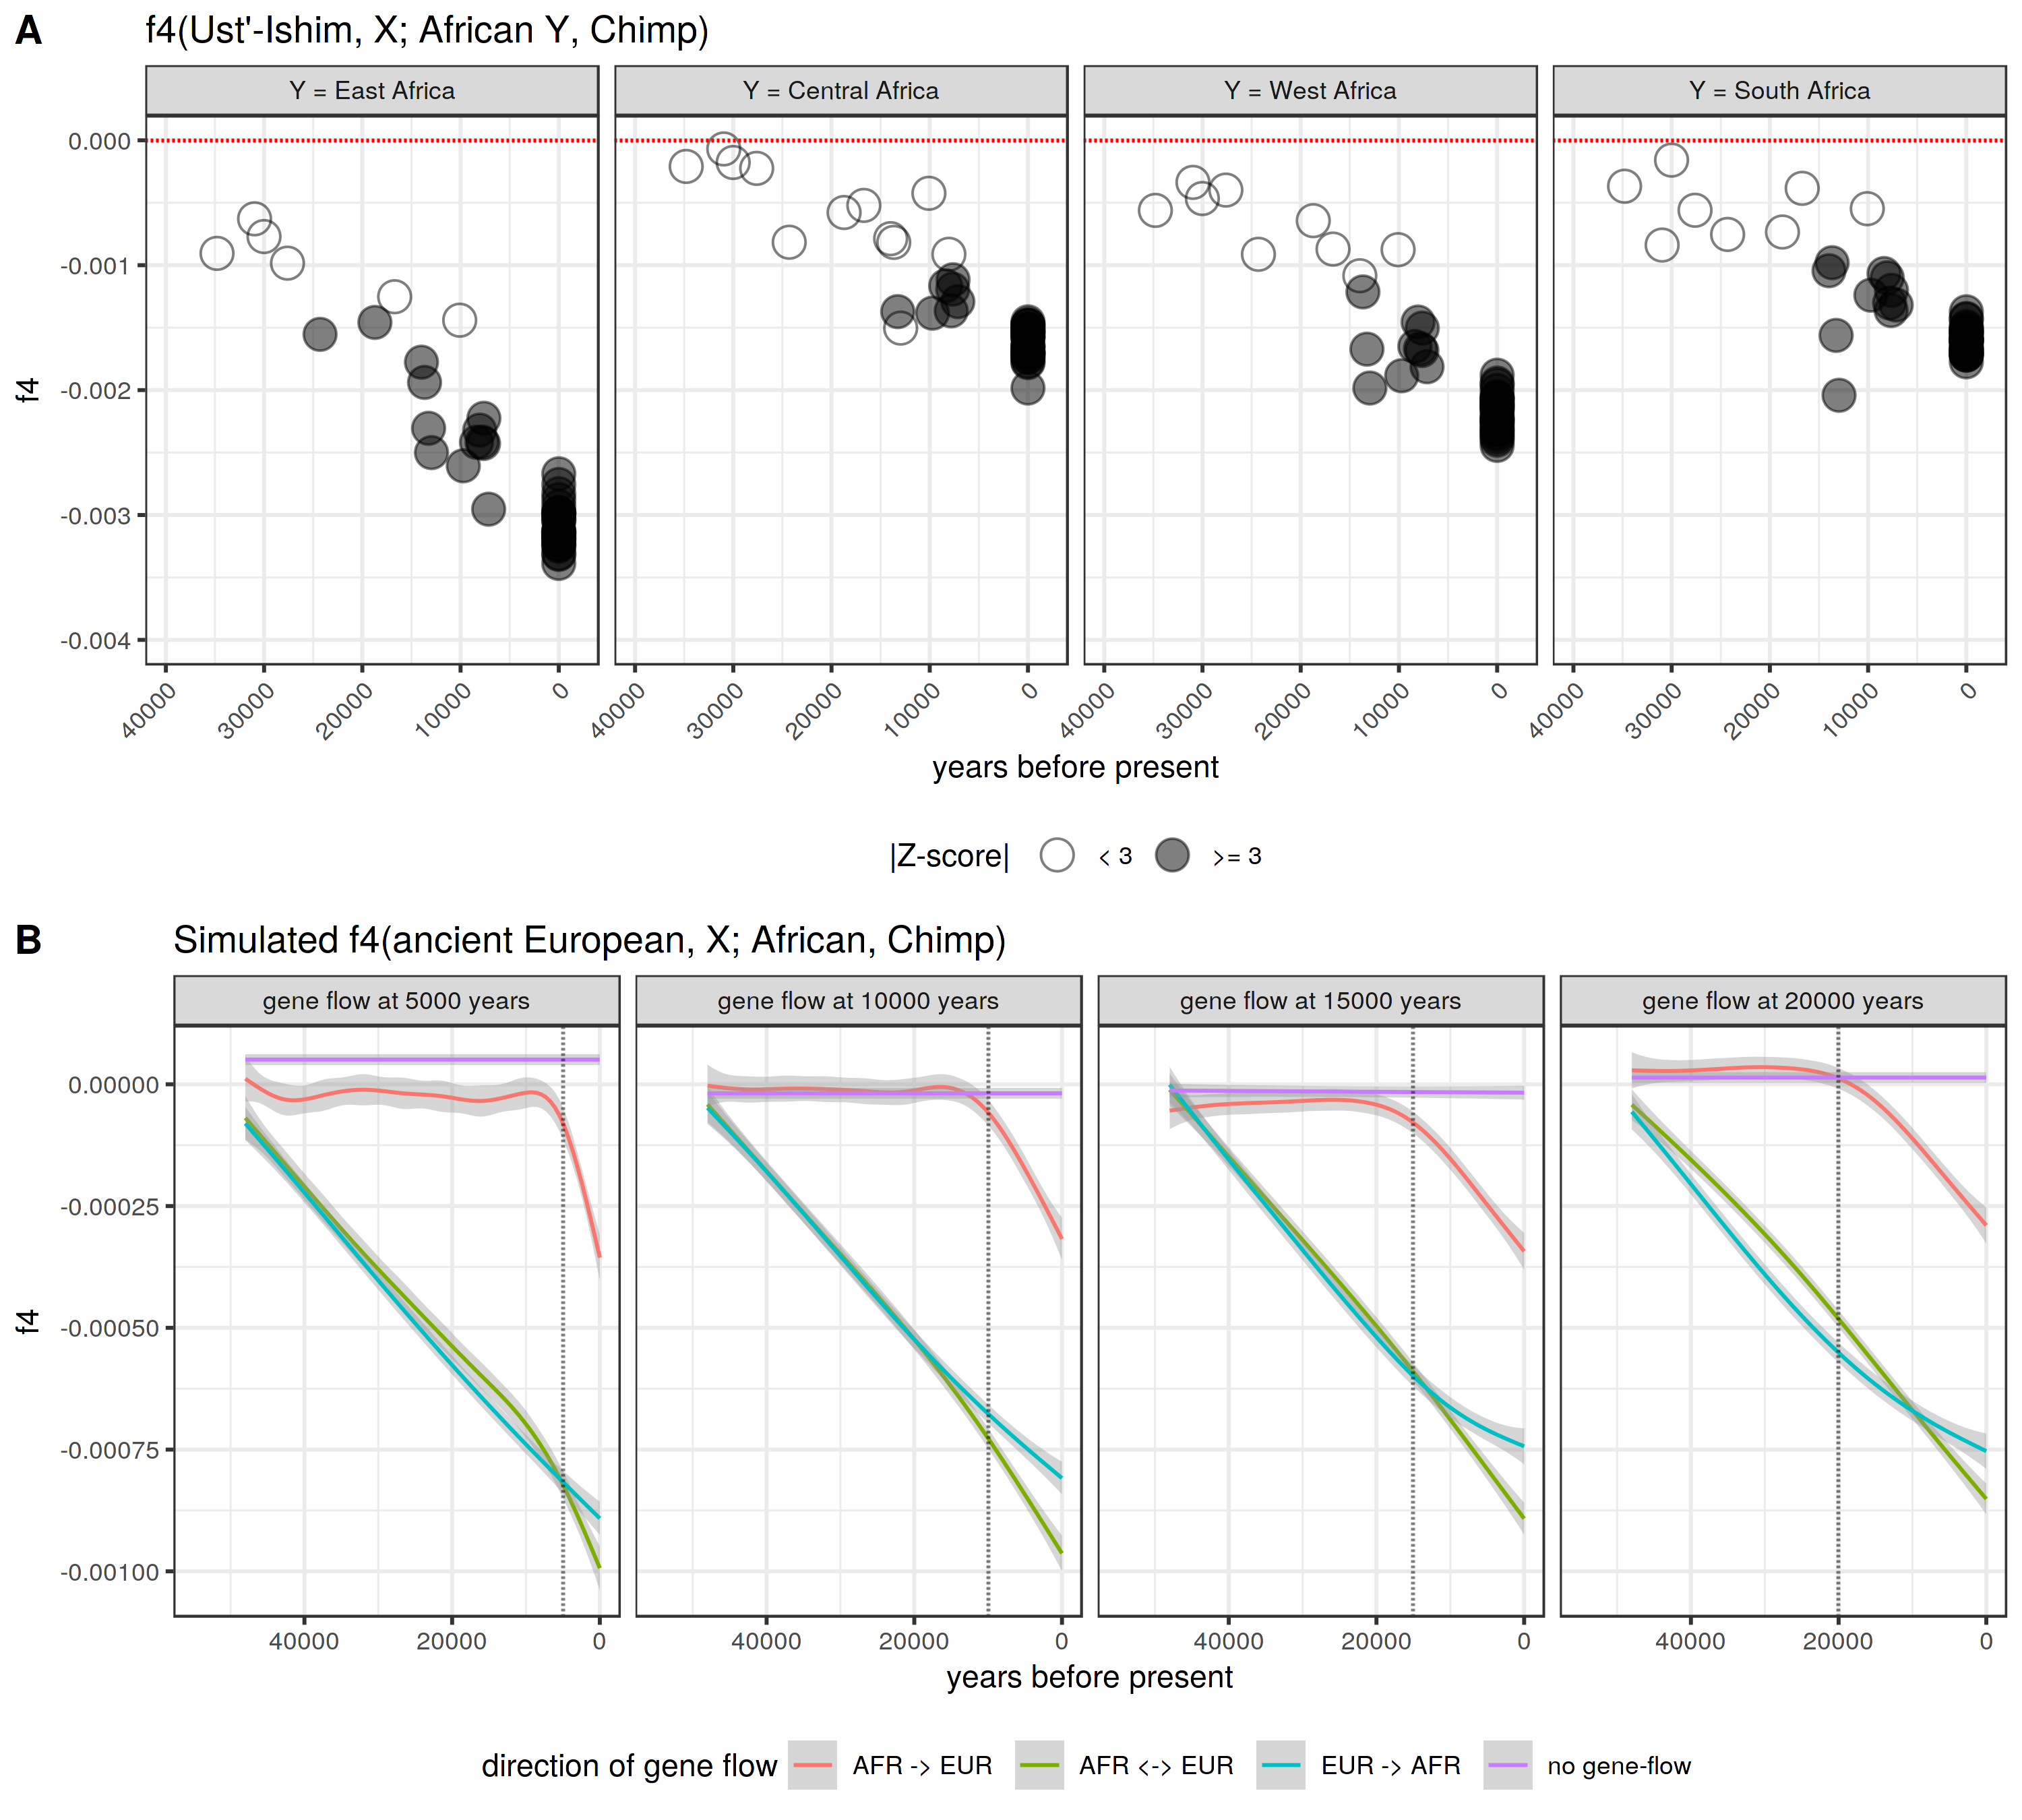

In [16]:
set_dim(10, 9, 300)

plot_grid(f4_real, f4_sim, labels = "AUTO", nrow = 2, rel_heights = c(1, 1))

ggsave(here("figures/S2.png"), width = 10, height = 8, units = "in")

## Individual Africans

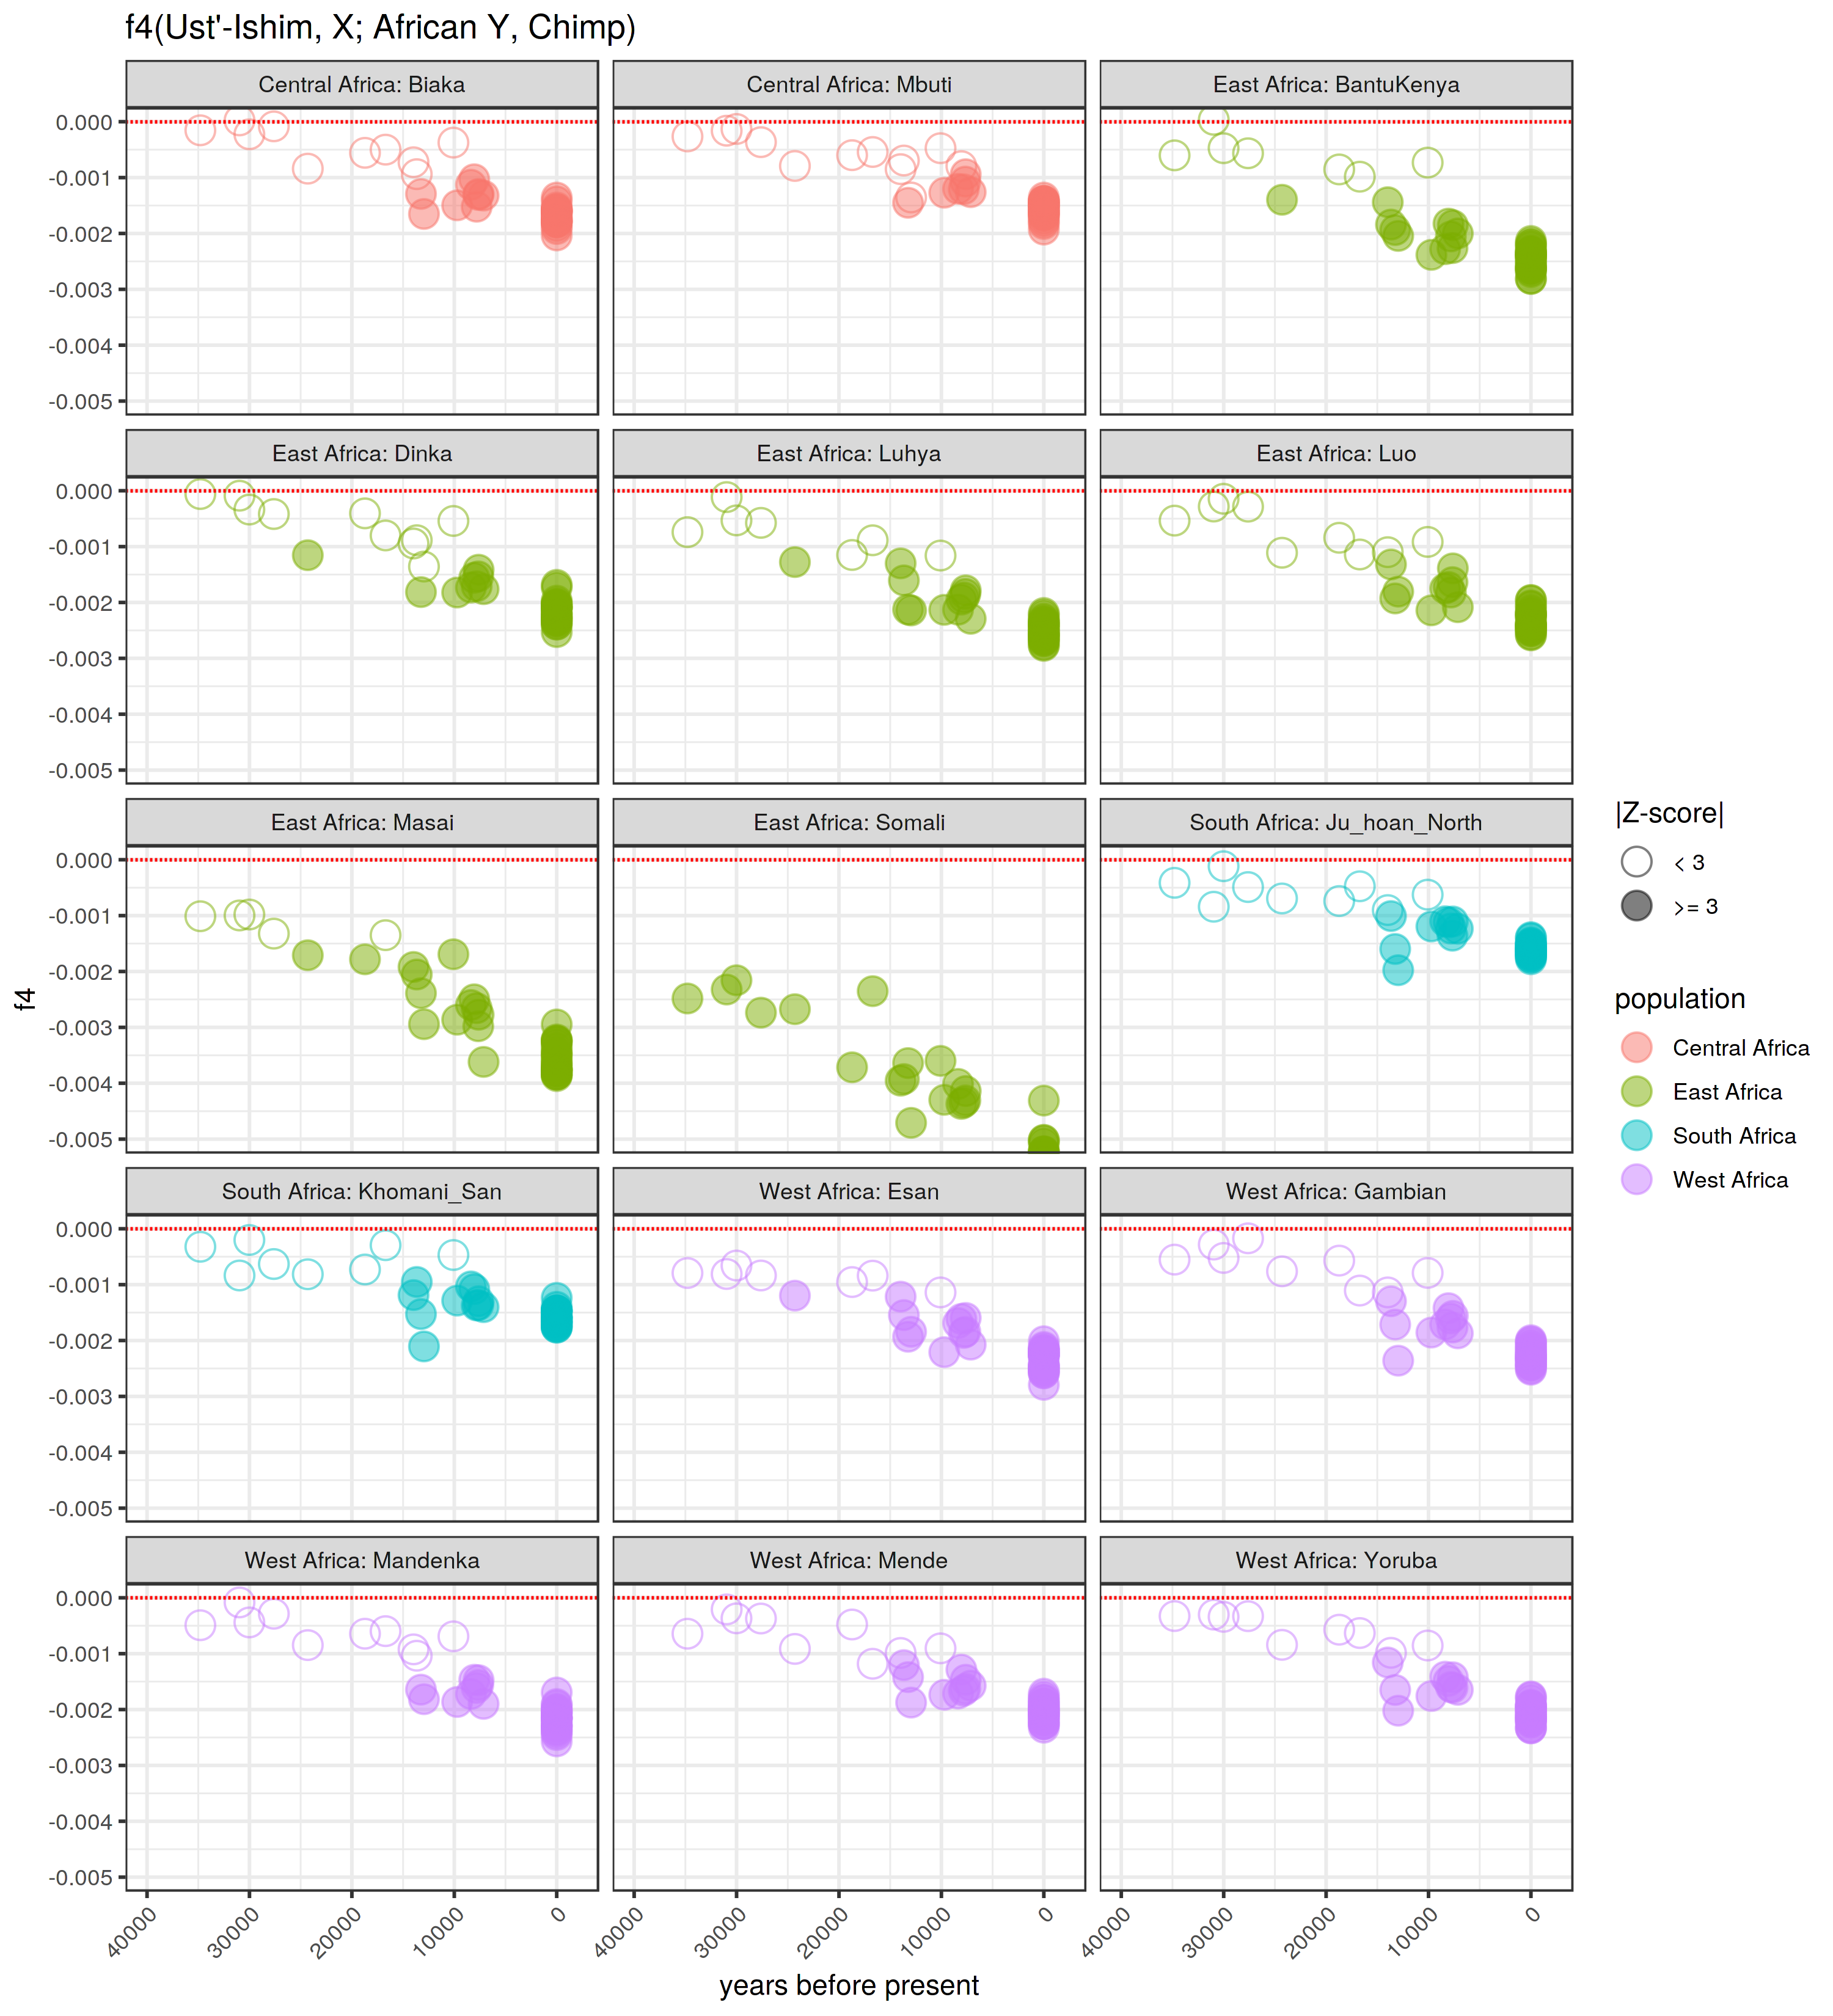

In [17]:
set_dim(10, 11, 300)

filter(affinity_chimp_ui, nsnps > 200000) %>%
filter(target_pop %in% c("EastAfrica", "CentralAfrica", "WestAfrica", "SouthAfrica"),
       X %notin% near_east) %>%
mutate(target_pop = str_replace(target_pop, "Africa", " Africa"),
       Y = target_pop %+% ": " %+% Y) %>% 
ggplot(aes(age, f4)) +
    geom_point(aes(shape = abs(Zscore) >= 3, color = target_pop), size = 5, alpha = 1/2) +
    geom_hline(yintercept = 0, linetype = 2, color = "red") +
    xlim(40000, -2000) + coord_cartesian(y = c(-0.005, 0.0)) +
    facet_wrap(~ Y, nc = 3) +
    xlab("years before present") + ylab("f4") +
    ggtitle("f4(Ust'-Ishim, X; African Y, Chimp)") +
    scale_shape_manual(name = "|Z-score|", labels = c("< 3", ">= 3"), values = c(21, 19)) +
    scale_color_discrete(name = "population") +
    theme_bw() + theme(axis.text.x = element_text(hjust = 1, angle = 45))

# Figure S4

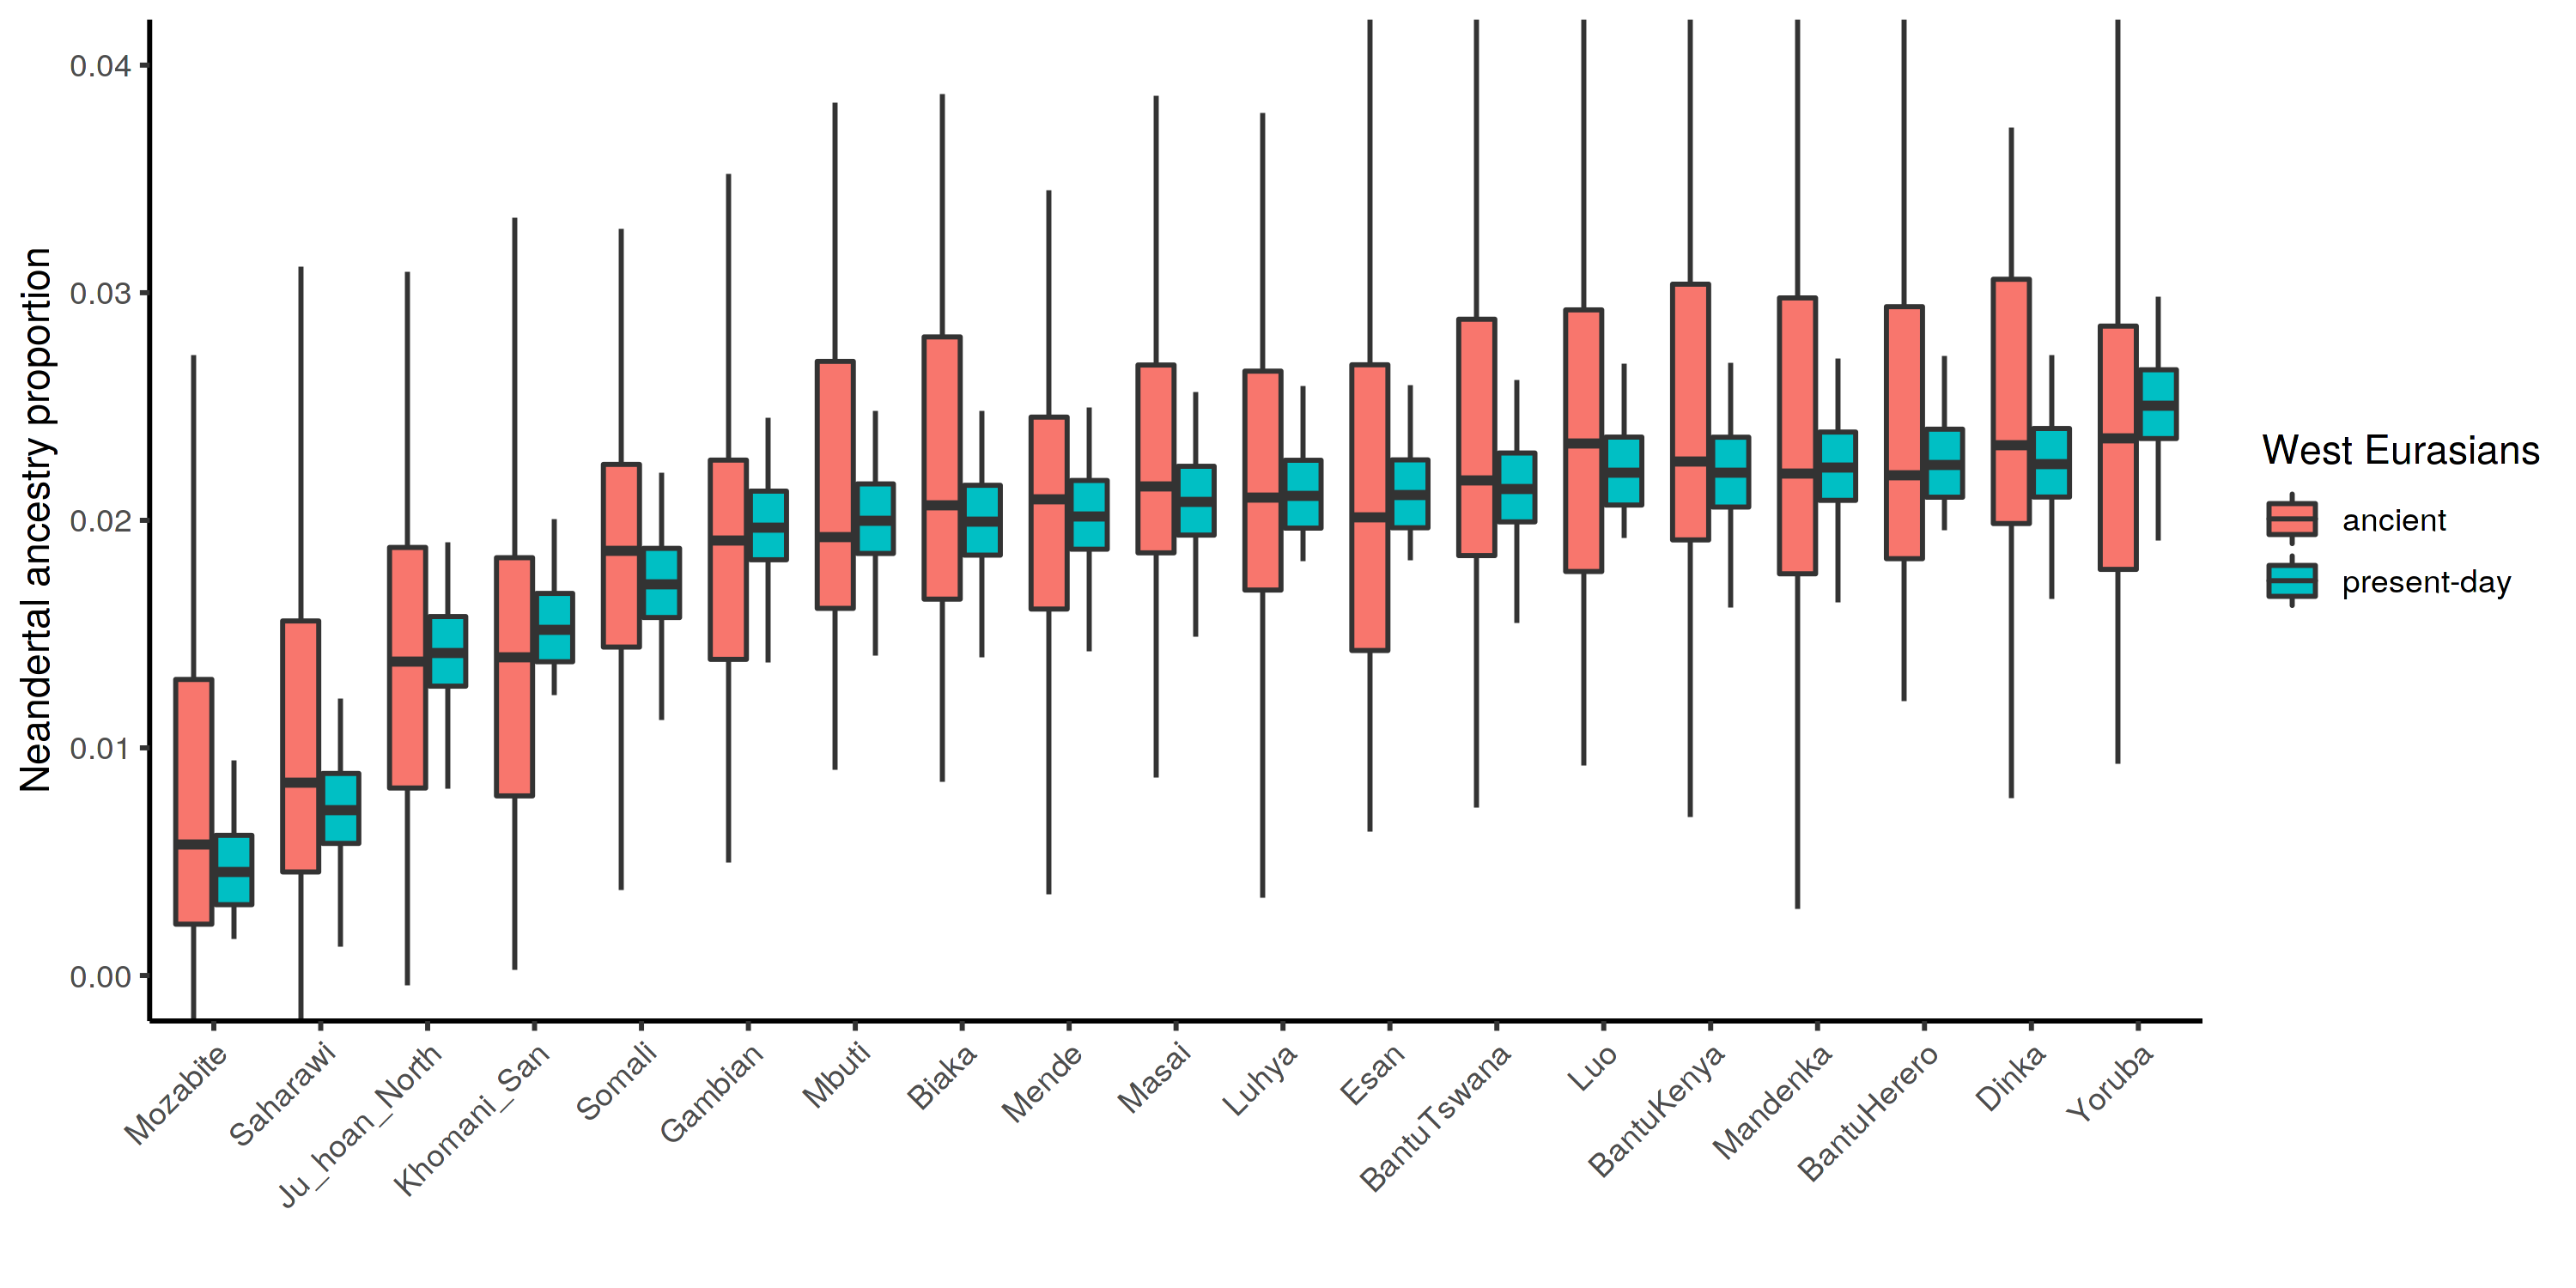

In [18]:
set_dim(10, 5, 300)

readRDS(here("data/rds/nea_estimates.rds")) %>%
filter(stat == "direct_f4", pop %in% c("EMH", "WestEurasia")) %>% 
ggplot(aes(fct_reorder(C, alpha), alpha, fill = pop)) +
    geom_boxplot(outlier.shape = NA) + coord_cartesian(y = c(0, 0.04)) +
    theme_classic() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    scale_fill_discrete(name = "West Eurasians", labels = c("ancient", "present-day")) +
    xlab("") + ylab("Neandertal ancestry proportion")

ggsave(here("figures/S4.png"), width = 10, height = 5, units = "in")

# Figure S5

# Figure S6

In [19]:
basal_eur <- readRDS(here("data/rds/basal_eur_array.rds"))

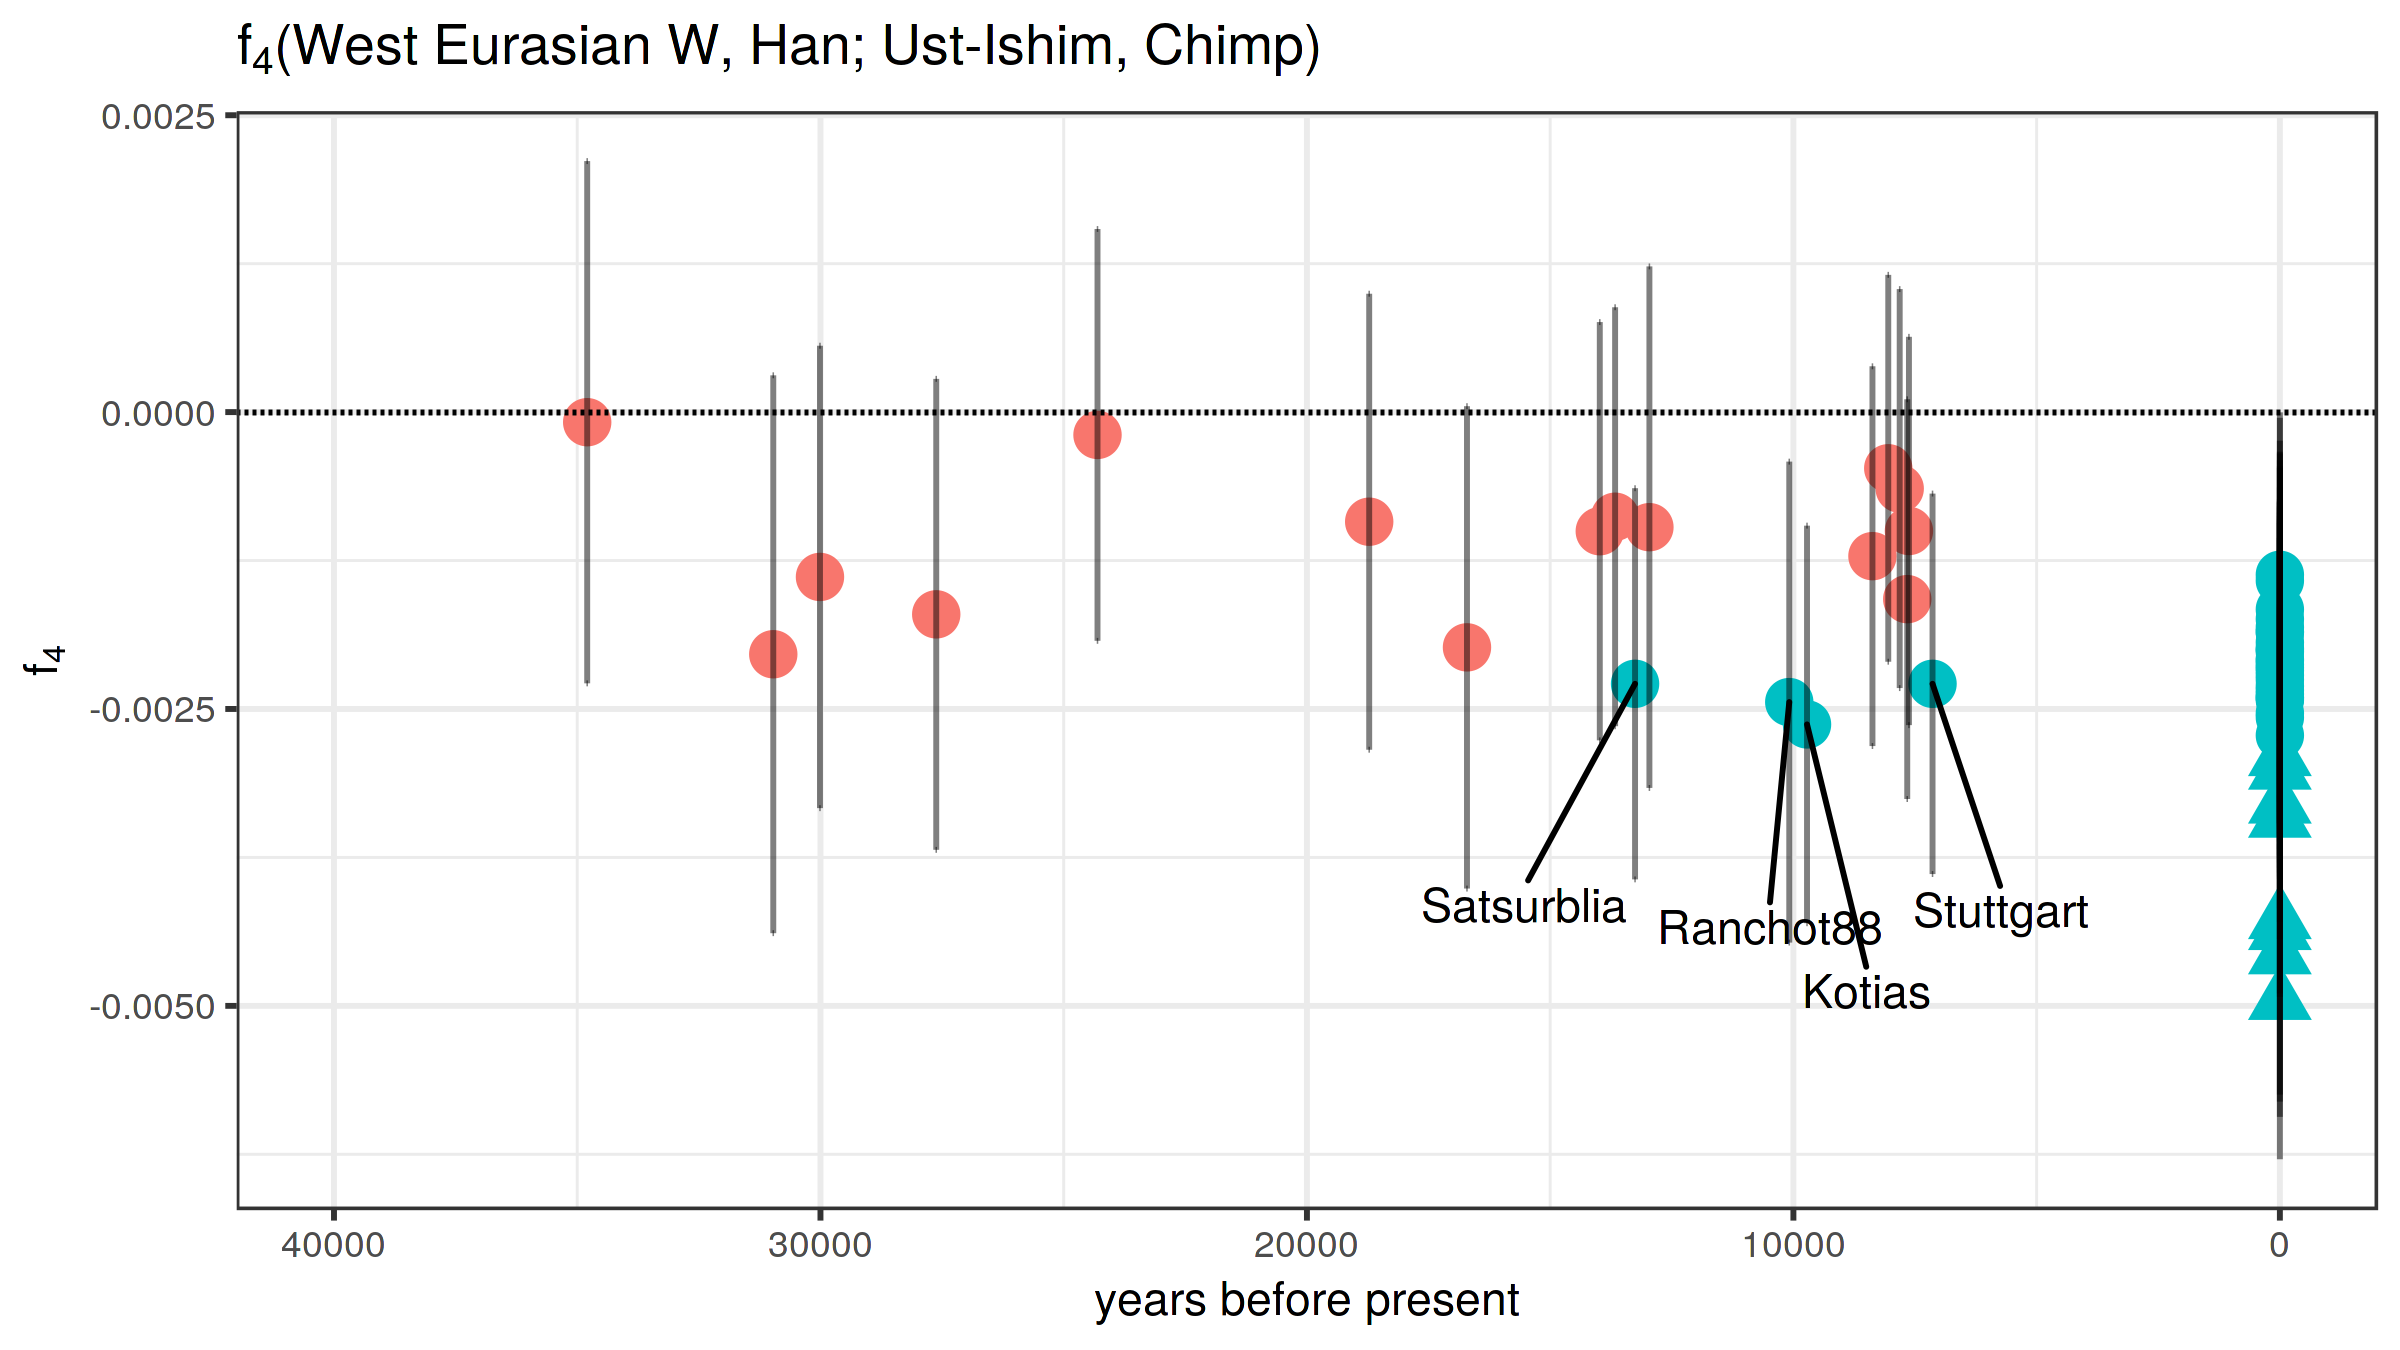

In [20]:
set_dim(8, 4.5, 300)

basal_eur %>% filter(X == "Han", nsnps > 200000) %>%
mutate(lbl = ifelse(W %in% c("Stuttgart", "Satsurblia", "Kotias", "Ranchot88"), W, ""),
       X = paste("X =", X)) %>% 
  ggplot(aes(age, f4)) +
  geom_point(aes(shape = W %in% near_east, color = abs(Zscore) > 3), size = 5) +
  geom_errorbar(aes(ymin = f4 - 3 * stderr, ymax = f4 + 3 * stderr), alpha = 0.5) +
  geom_hline(yintercept = 0, linetype = 2, color = "black") +
  geom_text_repel(aes(label = lbl), color = "black", nudge_y = -0.002) +
  ggtitle(TeX("$f_4$(West Eurasian W, Han; Ust-Ishim, Chimp)")) +
  theme_bw() +
  theme(legend.position = "none") +
#  facet_grid(X ~ .) +
  xlim(40000, 0) + xlab("years before present") + ylab(TeX("$f_4$"))

ggsave(here("figures/S6.png"), width = 8, height = 4.5, units = "in")

# Figure S7

In [21]:
nea_be <- readRDS(here("data/rds/nea_be_wgs.rds"))

t.test(alpha ~ group, nea_be)
t.test(f4 ~ group, nea_be)


	Welch Two Sample t-test

data:  alpha by group
t = -6.4491, df = 13.805, p-value = 1.631e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.003353989 -0.001678205
sample estimates:
           mean in group Near East mean in group other West Eurasians 
                        0.01762713                         0.02014322 



	Welch Two Sample t-test

data:  f4 by group
t = -5.6959, df = 7.8442, p-value = 0.0004904
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0005842207 -0.0002466682
sample estimates:
           mean in group Near East mean in group other West Eurasians 
                     -0.0009560000                      -0.0005405556 


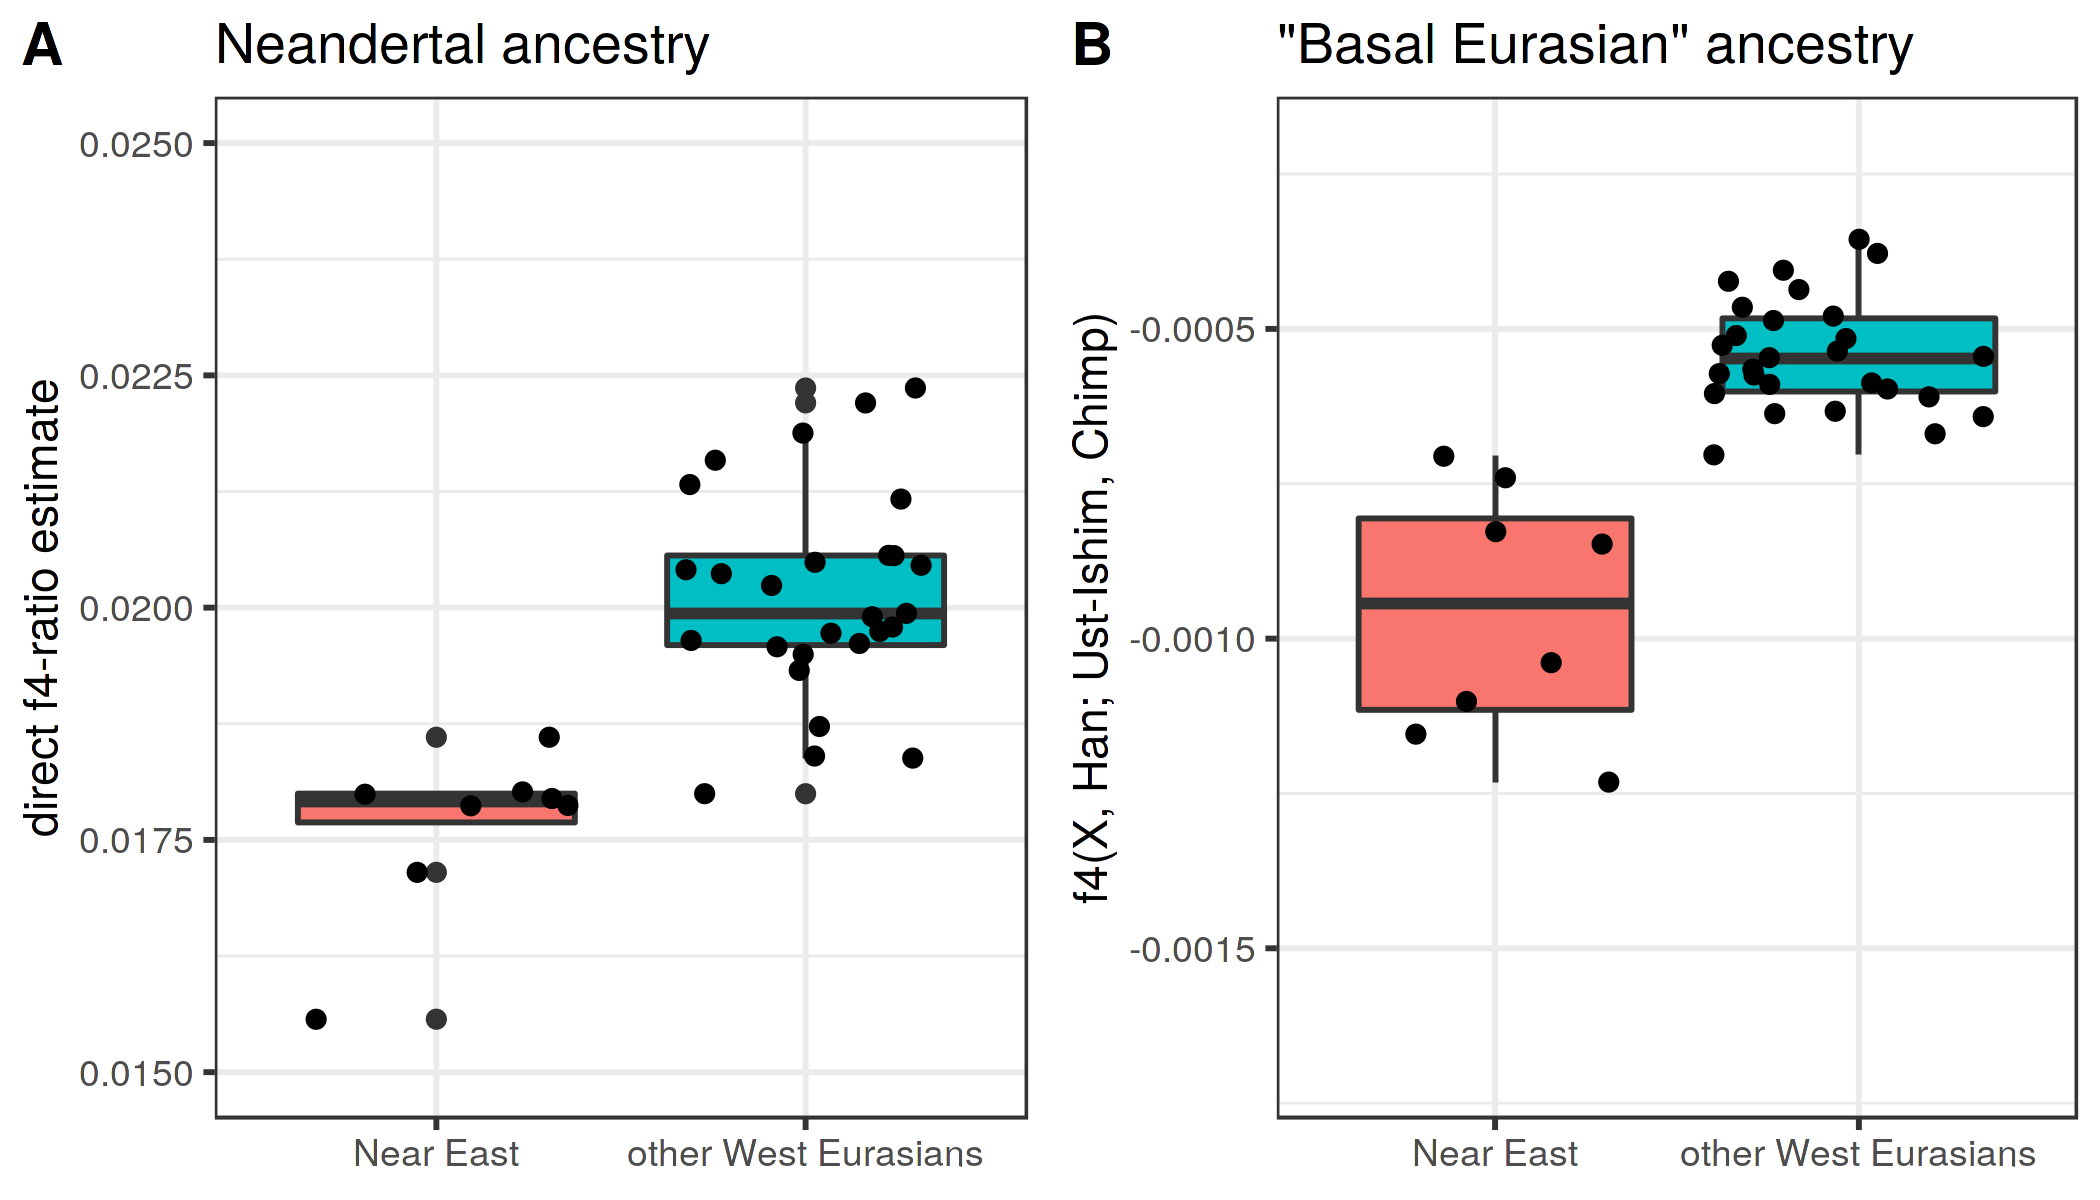

In [22]:
nea_dist_p <- ggplot(nea_be, aes(group, alpha, fill = group)) +
  geom_boxplot() + geom_jitter() +
  theme_bw() + theme(legend.position = "none") +
  ylab("direct f4-ratio estimate") +
  ggtitle("Neandertal ancestry") +
  ylim(0.015, 0.025) + theme(axis.title.x = element_blank())

be_dist_p <- ggplot(nea_be, aes(group, f4, fill = group)) +
  geom_boxplot() + geom_jitter() +
  theme_bw() + theme(legend.position = "none") +
  ylab("f4(X, Han; Ust-Ishim, Chimp)") +
  ggtitle("\"Basal Eurasian\" ancestry") +
  ylim(-0.0017, -0.0002) + theme(axis.title.x = element_blank())

set_dim(7, 4, 300)
plot_grid(nea_dist_p, be_dist_p, labels = "AUTO")

ggsave(here("figures/S7.png"), width = 7, height = 4, units = "in")

# Figure S8

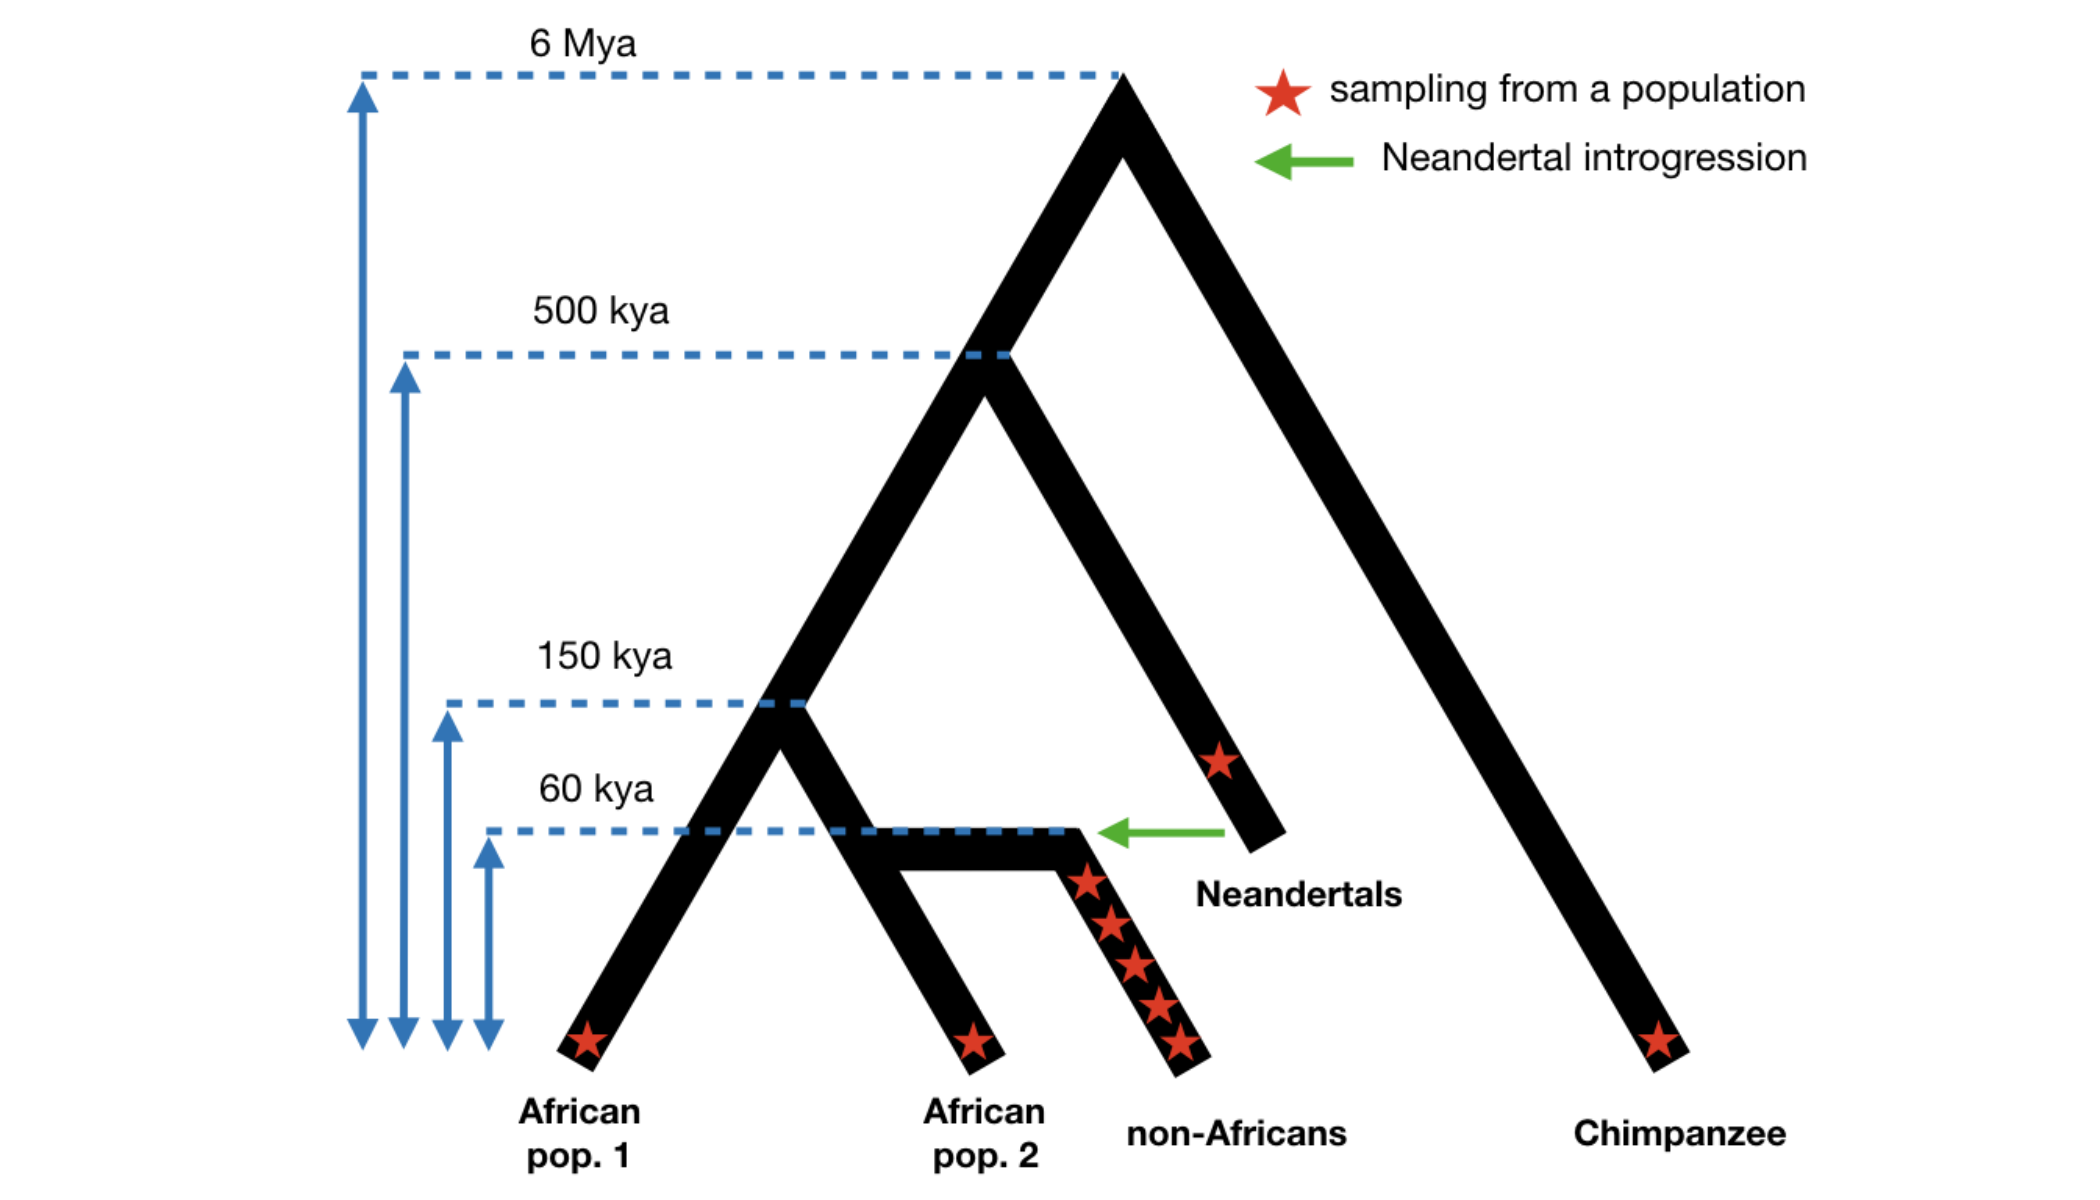

In [23]:
ggdraw() + draw_image(here("figures/diagrams/msprime.png"))

# Figure S9

In [24]:
set_dim(7, 4, 300)

p1 <- list.files(here("data/simulations"), pattern = "^traj_Ne*", full.names = TRUE) %>%
map_dfr(~ suppressMessages(read_tsv(.x)) %>% mutate(model = str_replace(basename(.x), "traj_", "") %>% str_replace("_exon.*", "") %>% str_replace("Ne_", "Nea Ne = "))) %>%
mutate(model = fct_relevel(model, "Nea Ne = " %+% c(100, 500, 1000, 10000))) %>% 
group_by(model, gen) %>% 
summarise(mean_rep=mean(mean), sd_rep=sd(mean), n_rep=n()) %>%
mutate(se_rep=sd_rep / sqrt(n_rep),
     lower_ci=mean_rep - qnorm(1 - (0.05 / 2)) * se_rep,
     upper_ci=mean_rep + qnorm(1 - (0.05 / 2)) * se_rep) %>% 
ggplot(aes(gen, mean_rep)) +
    geom_line(aes(color = model), linetype = 2) +
    geom_ribbon(aes(ymin=lower_ci, ymax=upper_ci, fill = model), alpha=1/2) +
    ylab("average Neandertal ancestry") + xlab("generation after admixture") +
    theme_bw() + coord_cartesian(y = c(0, 0.1))

p2 <- p1 + scale_x_log10() + xlab("generation after admixture (log scale)")

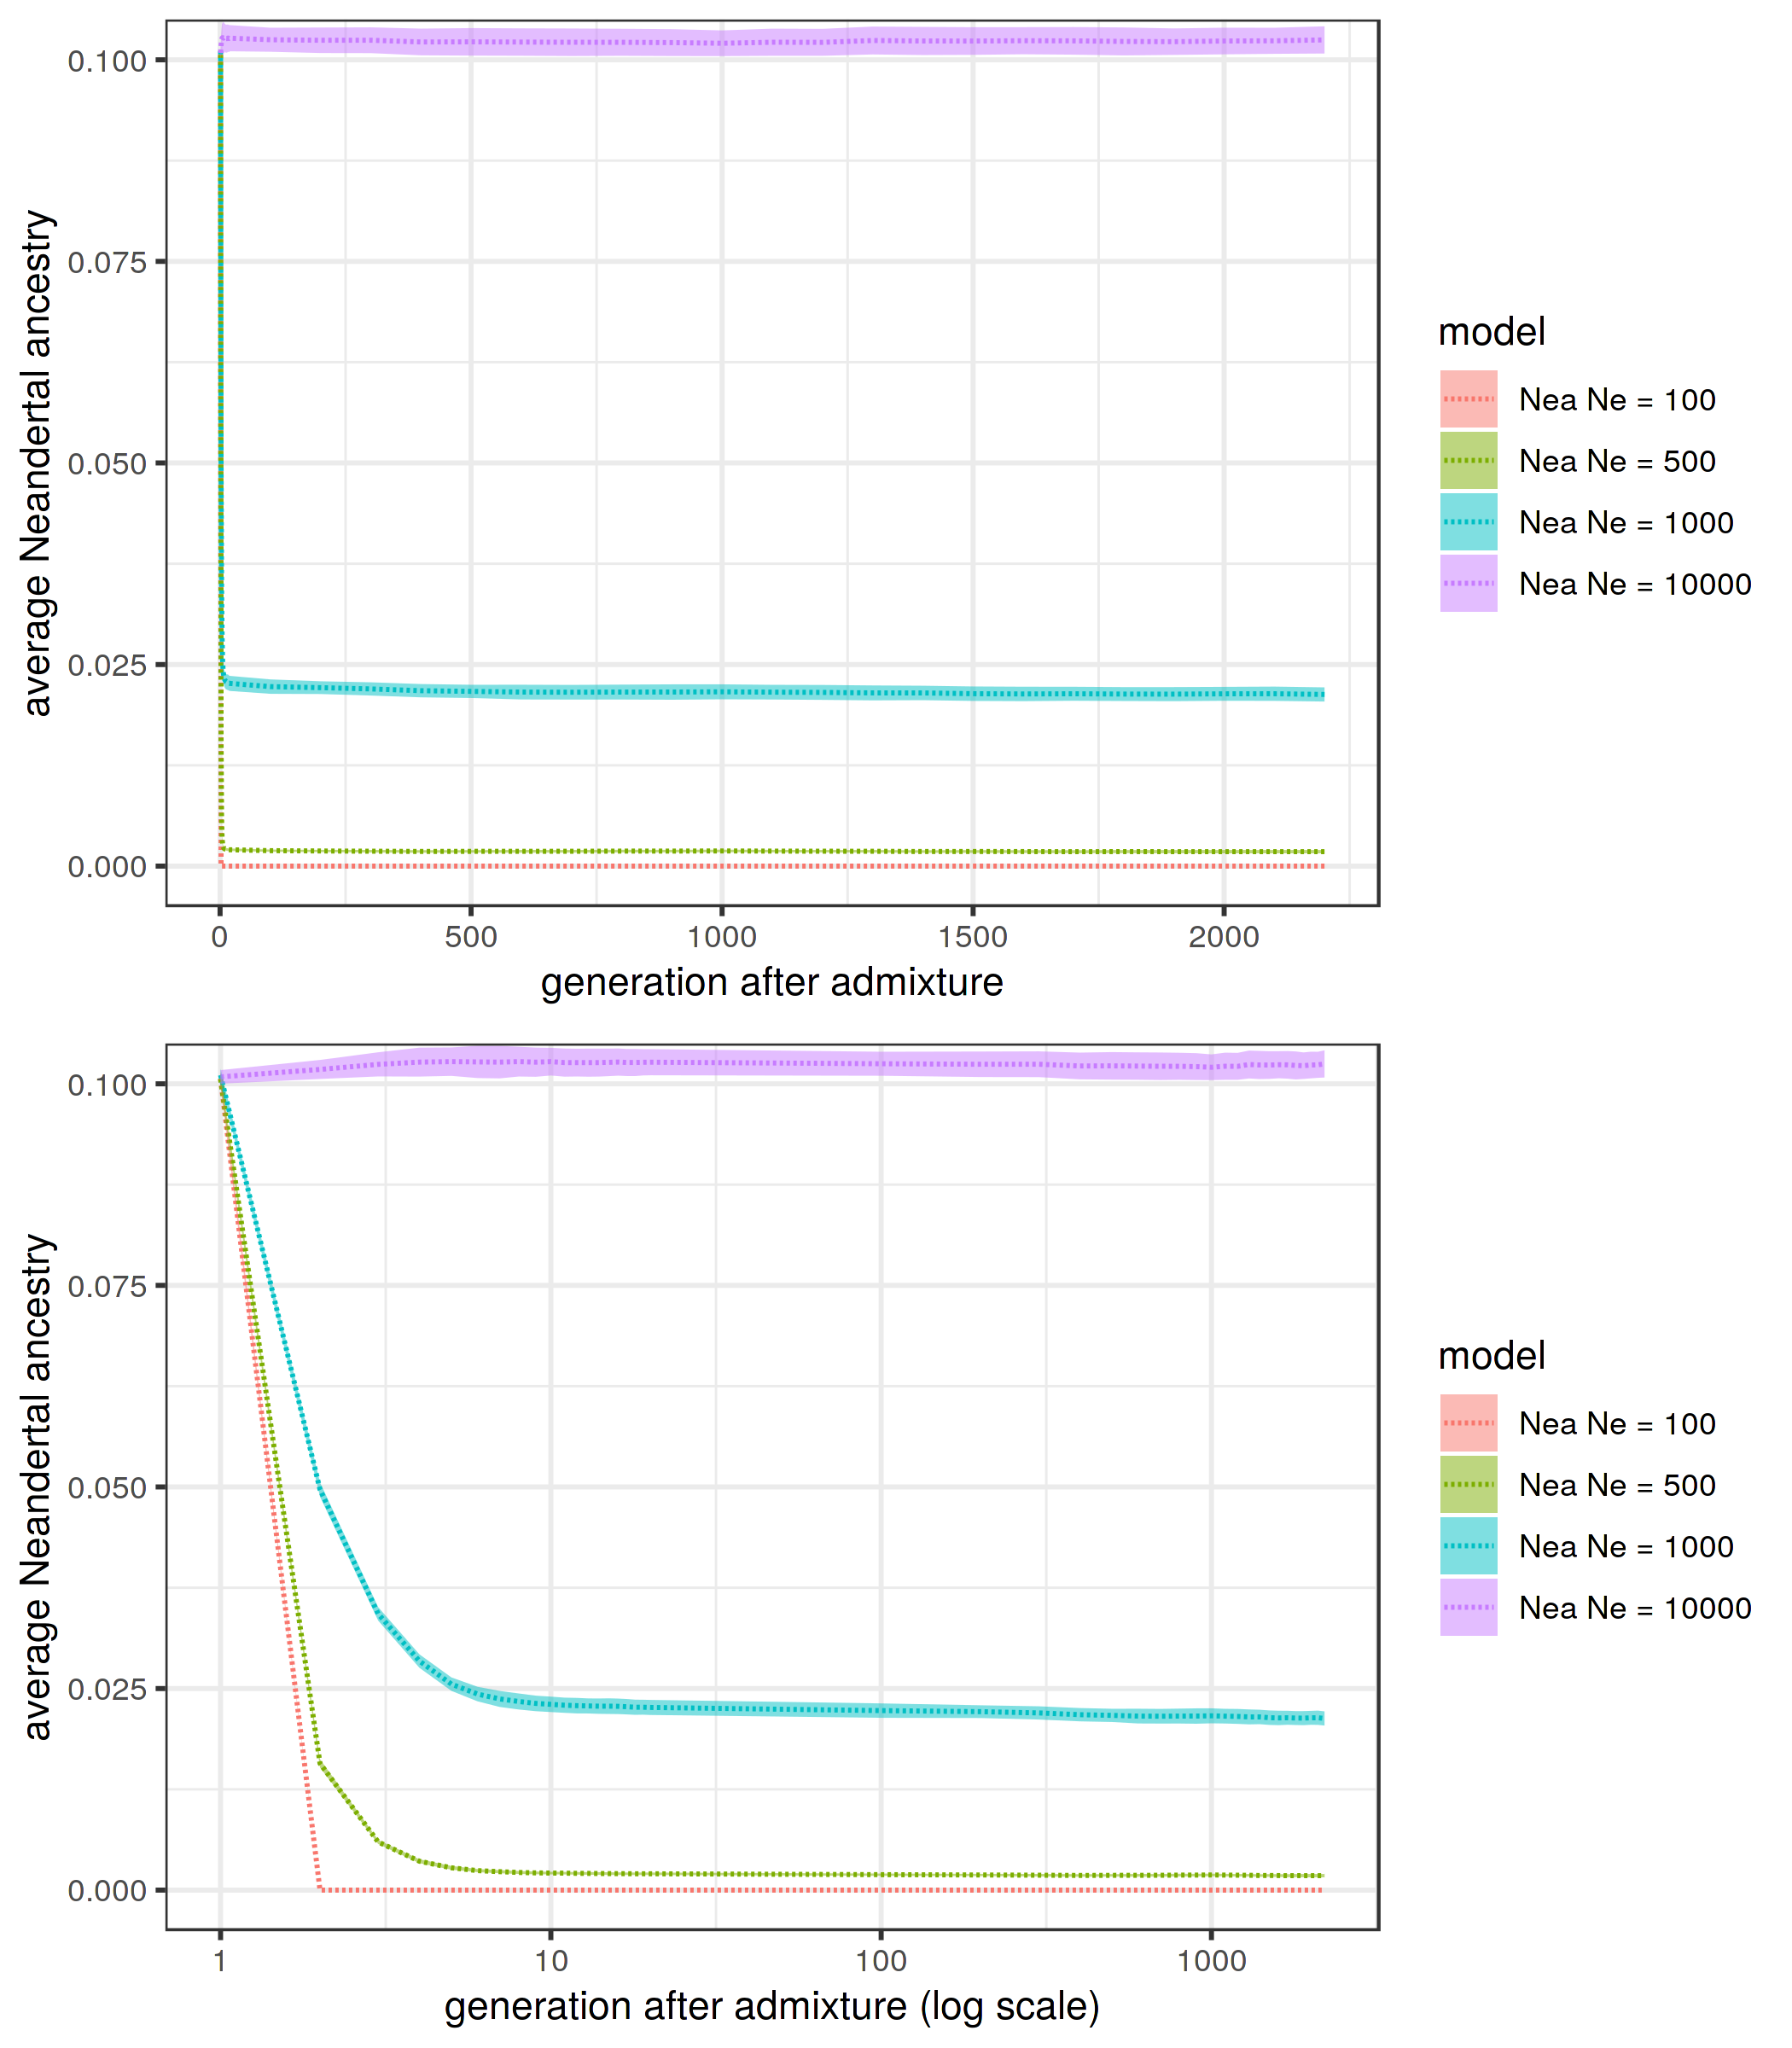

In [25]:
set_dim(7, 8, 300)

plot_grid(p1, p2, nrow = 2)

ggsave(here("figures/S9.png"), width = 7, height = 8, units = "in")

# Figure S10

In [26]:
set_dim(7, 4, 300)

p1 <- bind_rows(
list.files(here("data/simulations"), pattern = "^traj_constant*", full.names = TRUE) %>% map_dfr(~ suppressMessages(read_tsv(.x)) %>% mutate(model = "constant")),
list.files(here("data/simulations"), pattern = "^traj_linear*", full.names = TRUE) %>% map_dfr(~ suppressMessages(read_tsv(.x)) %>% mutate(model = "linear + exponential")),
list.files(here("data/simulations"), pattern = "^traj_gravel*", full.names = TRUE) %>% map_dfr(~ suppressMessages(read_tsv(.x)) %>% mutate(model = "Gravel et al. (2011)"))
) %>%
group_by(model, gen) %>% 
summarise(mean_rep=mean(mean), sd_rep=sd(mean), n_rep=n()) %>%
mutate(se_rep=sd_rep / sqrt(n_rep),
     lower_ci=mean_rep - qnorm(1 - (0.05 / 2)) * se_rep,
     upper_ci=mean_rep + qnorm(1 - (0.05 / 2)) * se_rep) %>% 
ggplot(aes(gen, mean_rep)) +
    geom_line(aes(color = model), linetype = 2) +
    geom_ribbon(aes(ymin=lower_ci, ymax=upper_ci, fill = model), alpha=1/5) +
    ylab("average Neandertal ancestry") + xlab("generation after admixture") +
    theme_bw() + coord_cartesian(y = c(0, 0.1))

p2 <- p1 + scale_x_log10() + xlab("generation after admixture (log scale)")

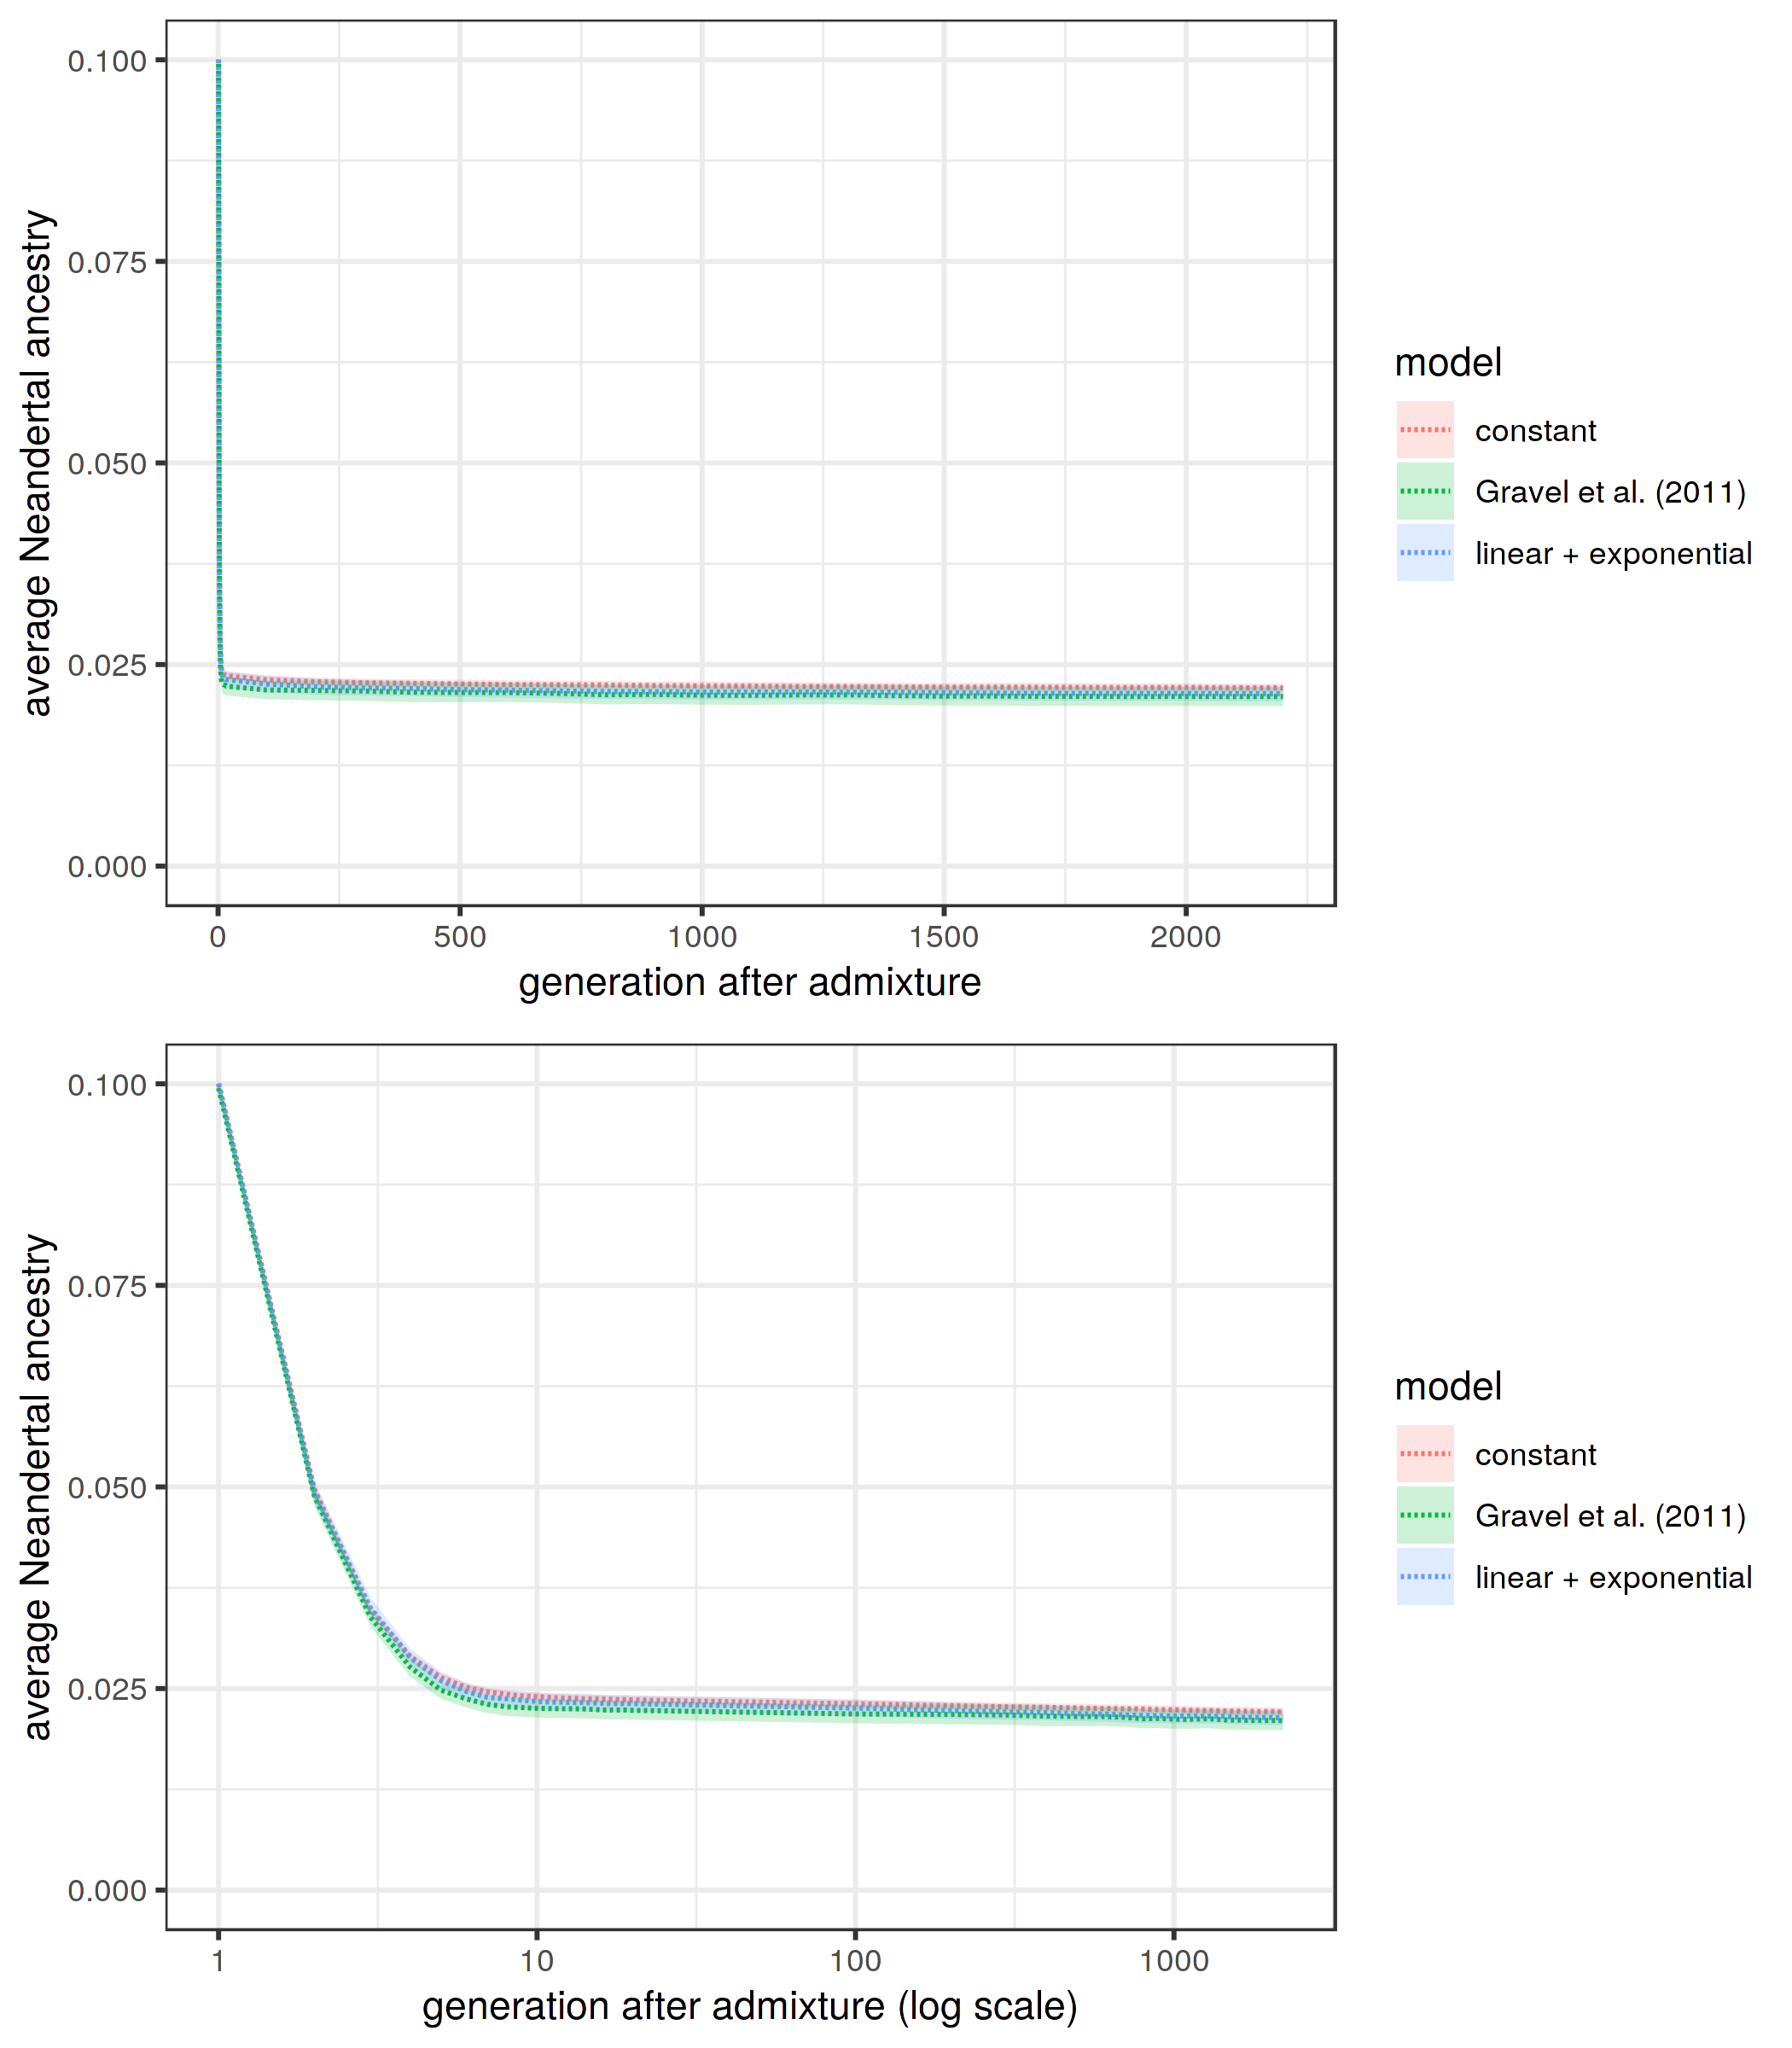

In [27]:
set_dim(7, 8, 300)

plot_grid(p1, p2, nrow = 2)

ggsave(here("figures/S10.png"), width = 7, height = 8, units = "in")

# Figure S11

In [28]:
set_dim(7, 4, 300)

p1 <- list.files(here("data/simulations"), pattern = "^traj_mult*", full.names = TRUE) %>%
map_dfr(~ suppressMessages(read_tsv(.x)) %>% mutate(model = str_replace(basename(.x), "data/simulations/traj_", "") %>%
                                      str_replace("_rep_.*", "") %>% str_replace("traj_mult_", "s x "))) %>%
group_by(model, gen) %>% 
summarise(mean_rep=mean(mean), sd_rep=sd(mean), n_rep=n()) %>%
mutate(se_rep=sd_rep / sqrt(n_rep),
     lower_ci=mean_rep - qnorm(1 - (0.05 / 2)) * se_rep,
     upper_ci=mean_rep + qnorm(1 - (0.05 / 2)) * se_rep) %>%
ungroup %>%
mutate(model = factor(model, labels = "s x " %+% c("1.0", 1.1, 1.25, 1.5, 1.75, "2.0", "5.0", "10.0"))) %>%
ggplot(aes(gen, mean_rep)) +
    geom_line(aes(color = model), linetype = 2) +
    geom_ribbon(aes(ymin=lower_ci, ymax=upper_ci, fill = model), alpha=1/2) +
    ylab("average Neandertal ancestry") + xlab("generation after admixture") +
    theme_bw() + coord_cartesian(y = c(0, 0.1))

p2 <- p1 + scale_x_log10() + xlab("generation after admixture (log scale)")

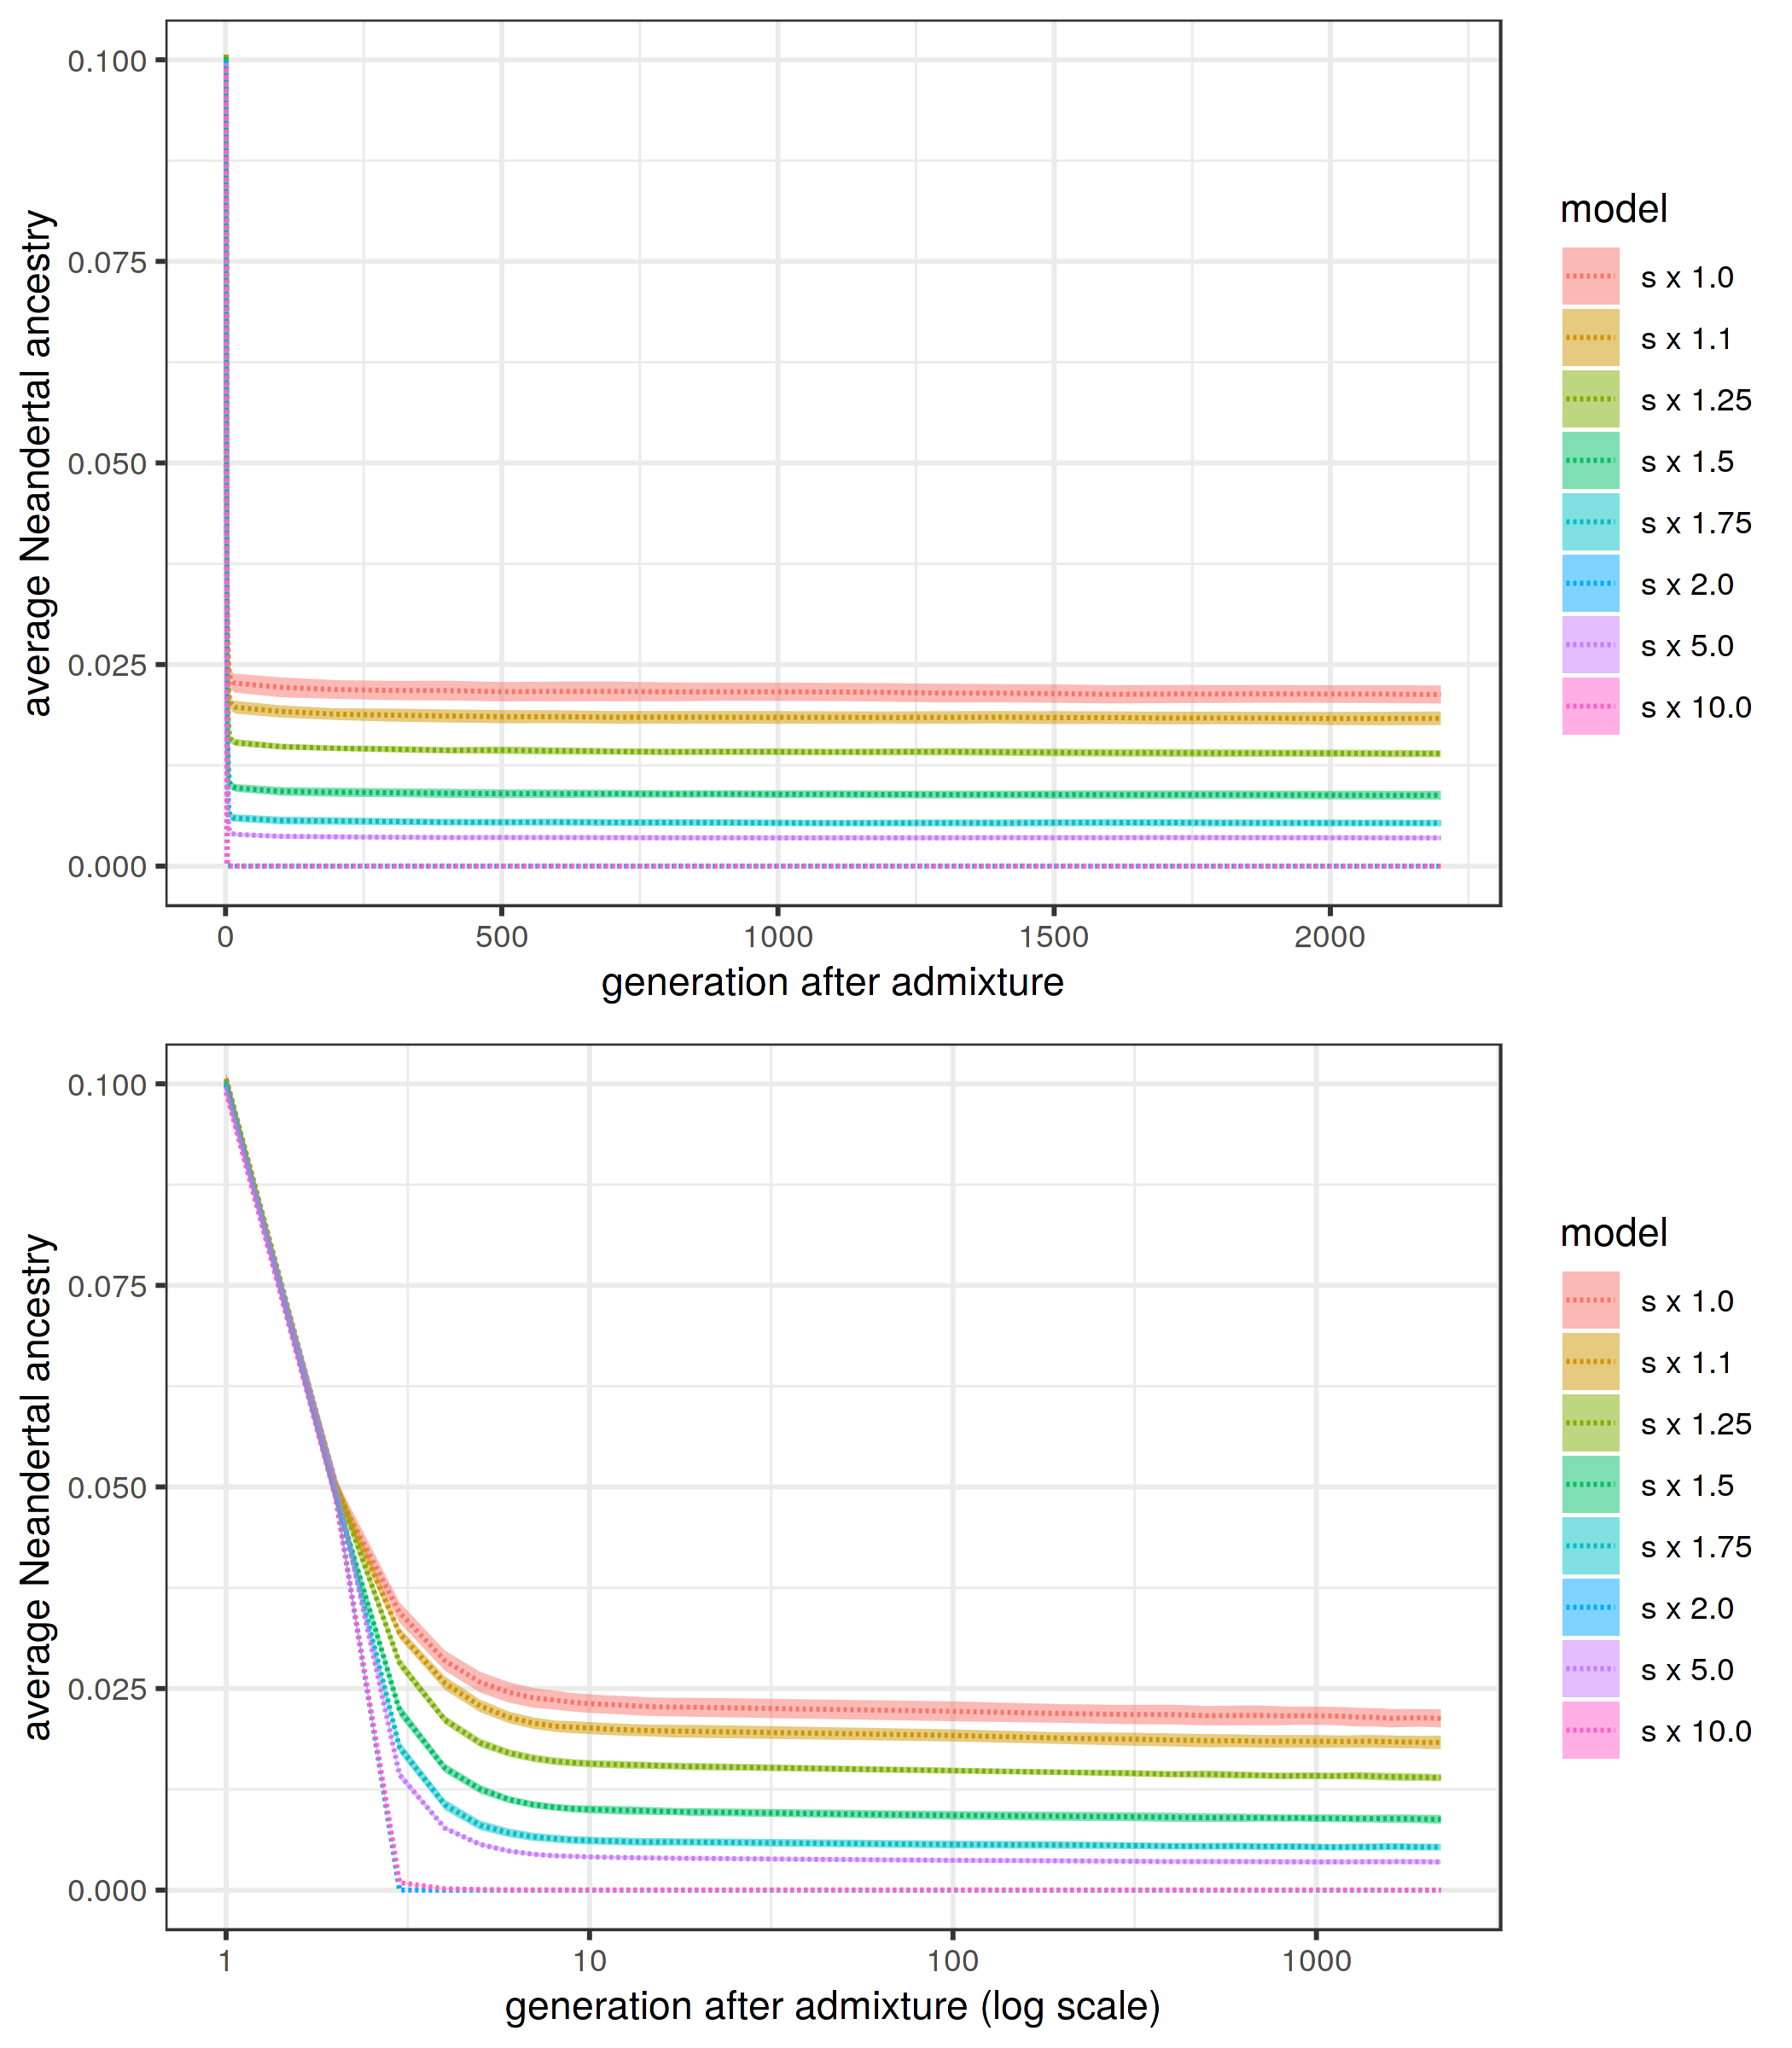

In [29]:
set_dim(7, 8, 300)

plot_grid(p1, p2, nrow = 2)

ggsave(here("figures/S11.png"), width = 7, height = 8, units = "in")

# Figure S12

In [30]:
set_dim(7, 4, 300)

p1 <- lapply(c("exon", "protein_coding", "tf_binding_site", "utr3", "promoter"), function(region) {
    list.files(here("data/simulations"), pattern = "^traj_" %+% region %+% "*", full.names = TRUE) %>%
        map_dfr(~ suppressMessages(read_tsv(.x)) %>% mutate(model = str_replace(basename(.x), "traj_", "") %>%
                                              str_replace("_rep_.*", "")))
    }) %>%
bind_rows %>%
group_by(model, gen) %>% 
summarise(mean_rep=mean(mean), sd_rep=sd(mean), n_rep=n()) %>%
mutate(se_rep=sd_rep / sqrt(n_rep),
     lower_ci=mean_rep - qnorm(1 - (0.05 / 2)) * se_rep,
     upper_ci=mean_rep + qnorm(1 - (0.05 / 2)) * se_rep) %>%
ungroup %>% 
mutate(model = case_when(model == "exon" ~ "exon (74 Mb)",
                         model == "promoter" ~ "promoter (23 MB)",
                         model == "protein_coding" ~ "protein coding (34 Mb)",
                         model == "tf_binding_site" ~ "TF binding site (10 Mb)",
                         model == "utr3" ~ "3' UTR (37 Mb)")) %>%
mutate(model = fct_relevel(model, c("exon (74 Mb)", "3' UTR (37 Mb)", "protein coding (34 Mb)",
                             "promoter (23 MB)", "TF binding site (10 Mb)"))) %>% 
ggplot(aes(gen, mean_rep)) +
    geom_line(aes(color = model), linetype = 2) +
    geom_ribbon(aes(ymin=lower_ci, ymax=upper_ci, fill = model), alpha=1/2) +
    ylab("average Neandertal ancestry") + xlab("generation after admixture") +
    theme_bw() + coord_cartesian(y = c(0, 0.1))

p2 <- p1 + scale_x_log10() + xlab("generation after admixture (log scale)")

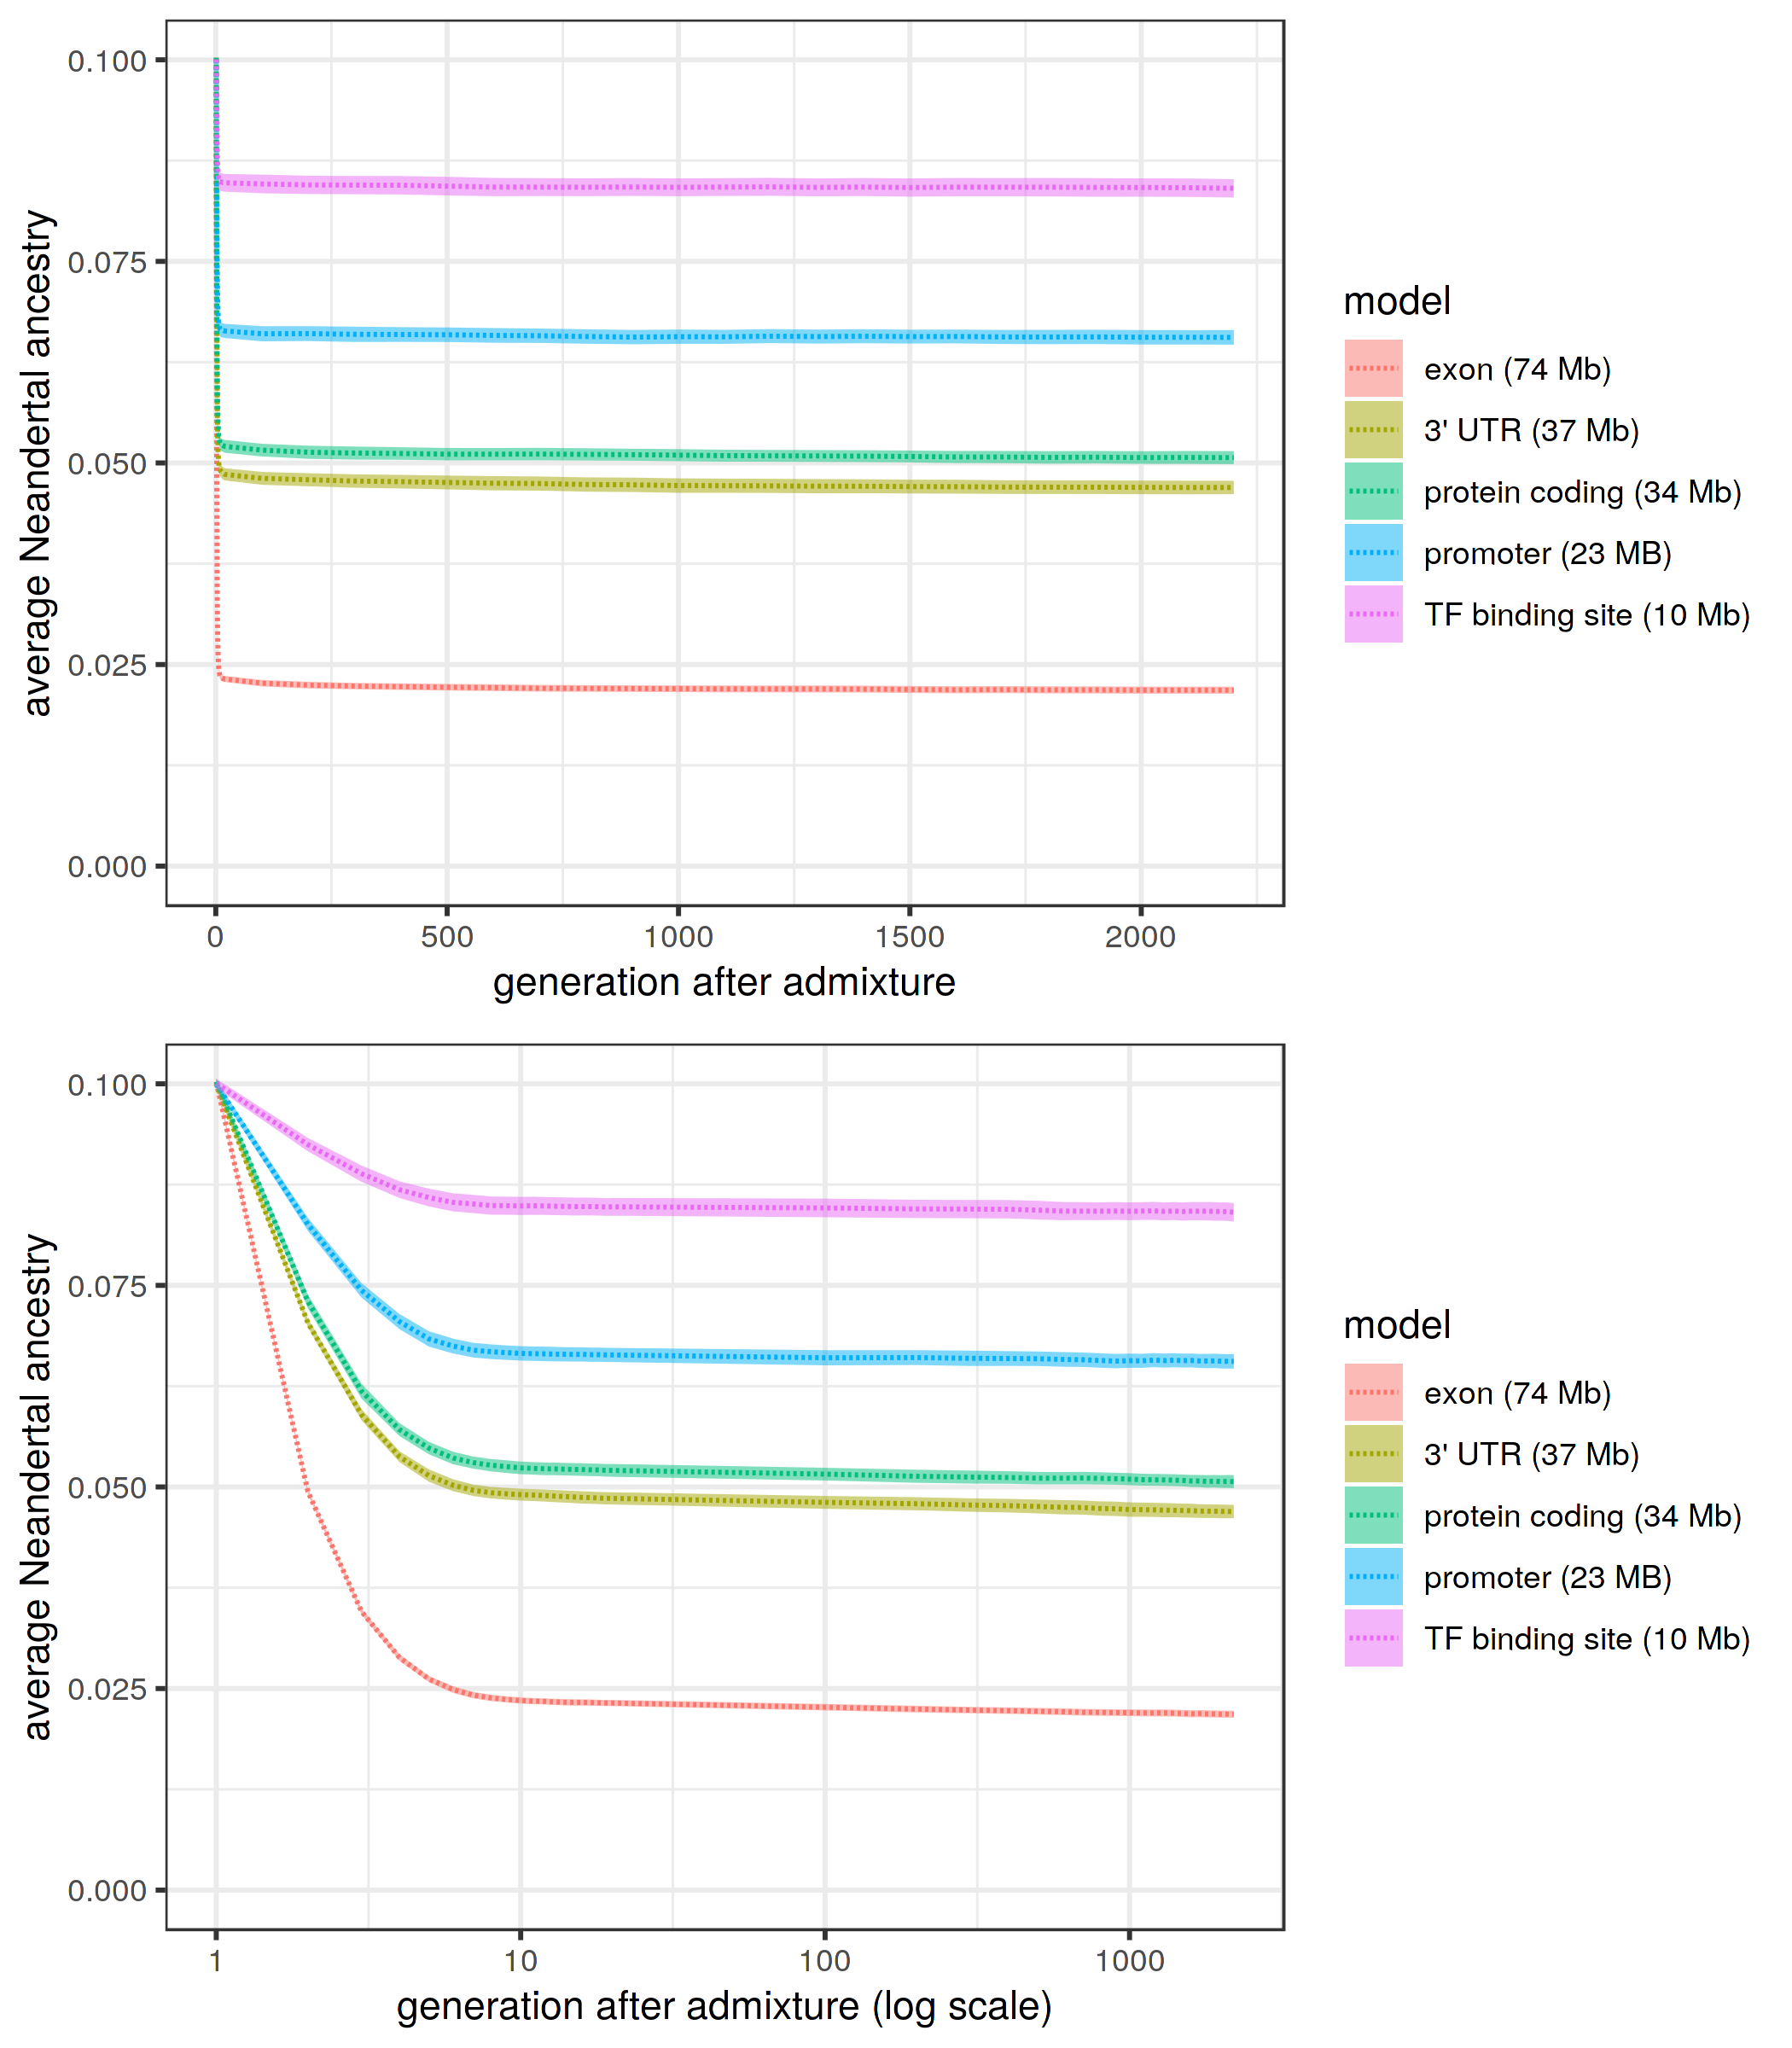

In [31]:
set_dim(7, 8, 300)

plot_grid(p1, p2, nrow = 2)

ggsave(here("figures/S12.png"), width = 7, height = 8, units = "in")

# Figure S13

In [32]:
set_dim(7, 4, 300)

# for translating fractions into %s
pct_tbl <- (seq(0, 100, 10) %+% "%") %>% setNames(c(seq(0, 1, 0.1)))

p1 <- list.files(here("data/simulations"), pattern = "^traj_mix*", full.names = TRUE) %>%
map_dfr(~ suppressMessages(read_tsv(.x)) %>%
        mutate(model = str_replace(basename(.x), "traj_mix_", "") %>%
                       str_replace("_rep_.*.txt", "") %>%
                       str_replace("add_", "") %>%
                       str_replace("0.0", "0") %>%
                       str_replace("1.0", "1")) %>%
        separate(model, sep = "_rec_", into = c("add", "rec")) %>%
        mutate(add = pct_tbl[add], rec = pct_tbl[rec]) %>% 
        mutate(model = add %+% " add., " %+% rec %+% " rec.")) %>% 
group_by(model, gen) %>% 
summarise(mean_rep=mean(mean), sd_rep=sd(mean), n_rep=n()) %>%
mutate(se_rep=sd_rep / sqrt(n_rep),
     lower_ci=mean_rep - qnorm(1 - (0.05 / 2)) * se_rep,
     upper_ci=mean_rep + qnorm(1 - (0.05 / 2)) * se_rep) %>%
ungroup %>% 
mutate(model = fct_reorder(model, mean_rep, .desc = TRUE)) %>% 
ggplot(aes(gen, mean_rep)) +
    geom_line(aes(color = model), linetype = 2) +
    geom_ribbon(aes(ymin=lower_ci, ymax=upper_ci, fill = model), alpha=1/2) +
    ylab("average Neandertal ancestry") + xlab("generation after admixture") +
    theme_bw() + coord_cartesian(y = c(0, 0.1))

p2 <- p1 + scale_x_log10() + xlab("generation after admixture (log scale)")

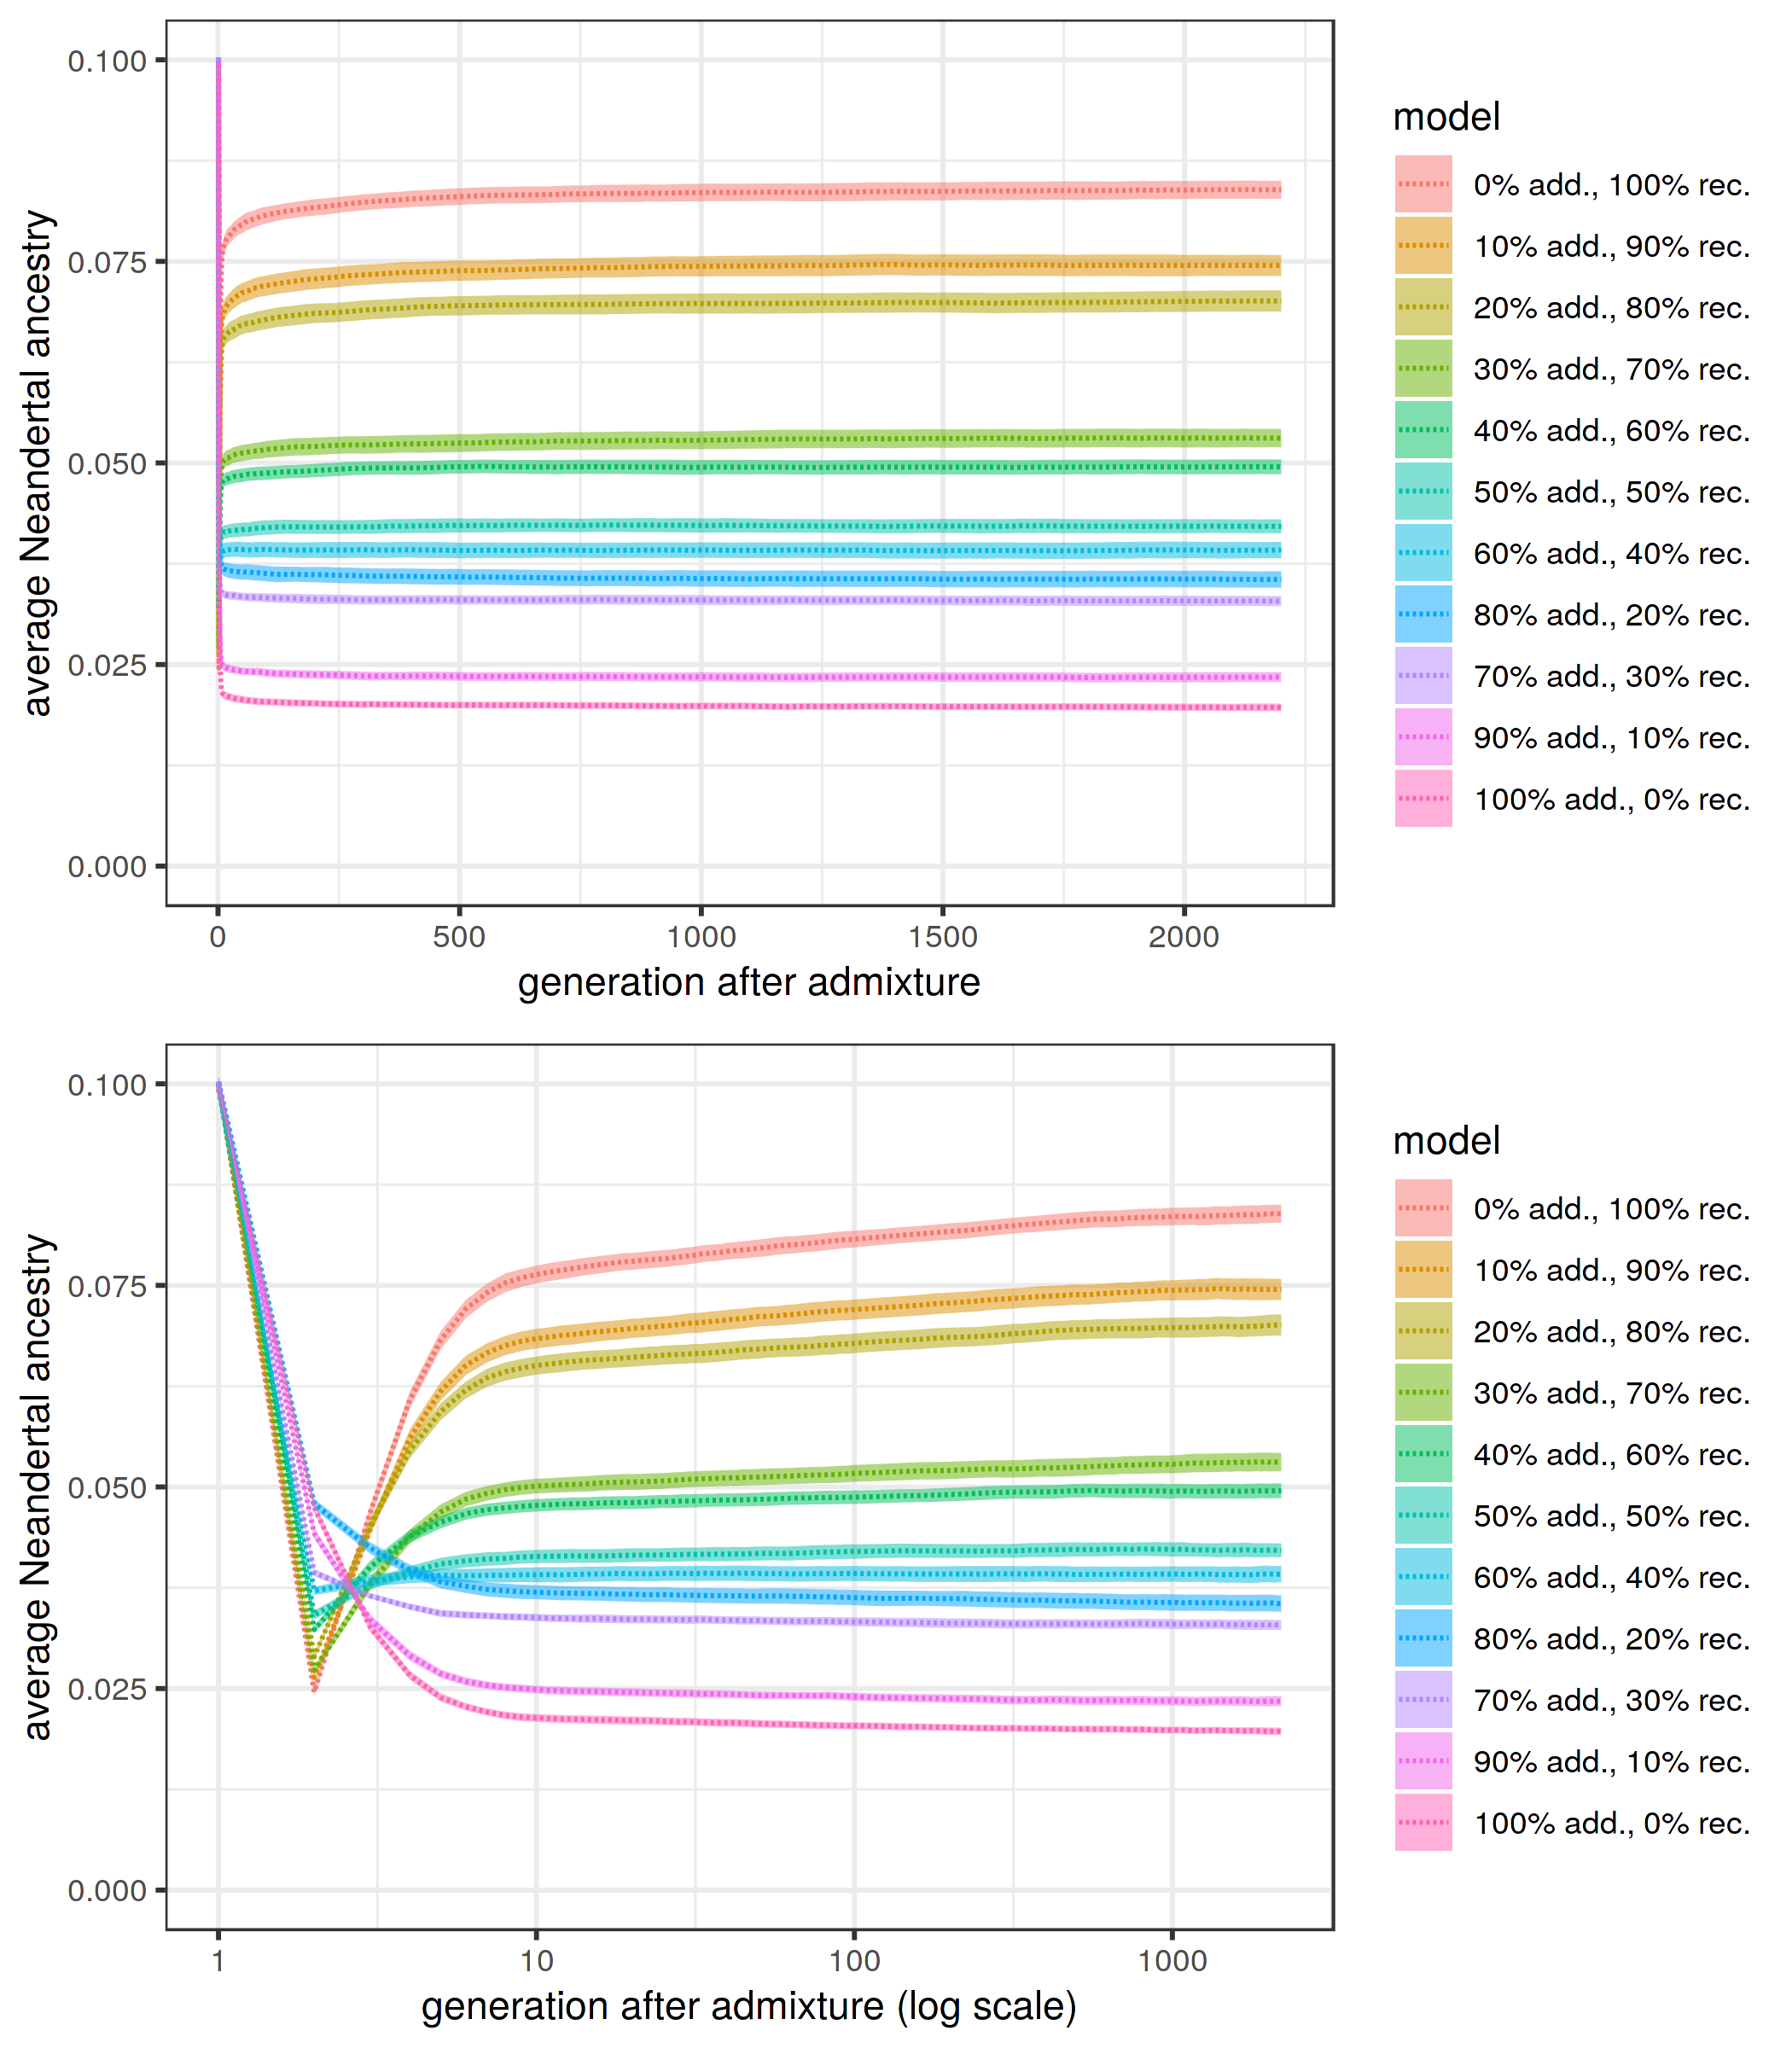

In [33]:
set_dim(7, 8, 300)

plot_grid(p1, p2, nrow = 2)

ggsave(here("figures/S13.png"), width = 7, height = 8, units = "in")

# Figure S14

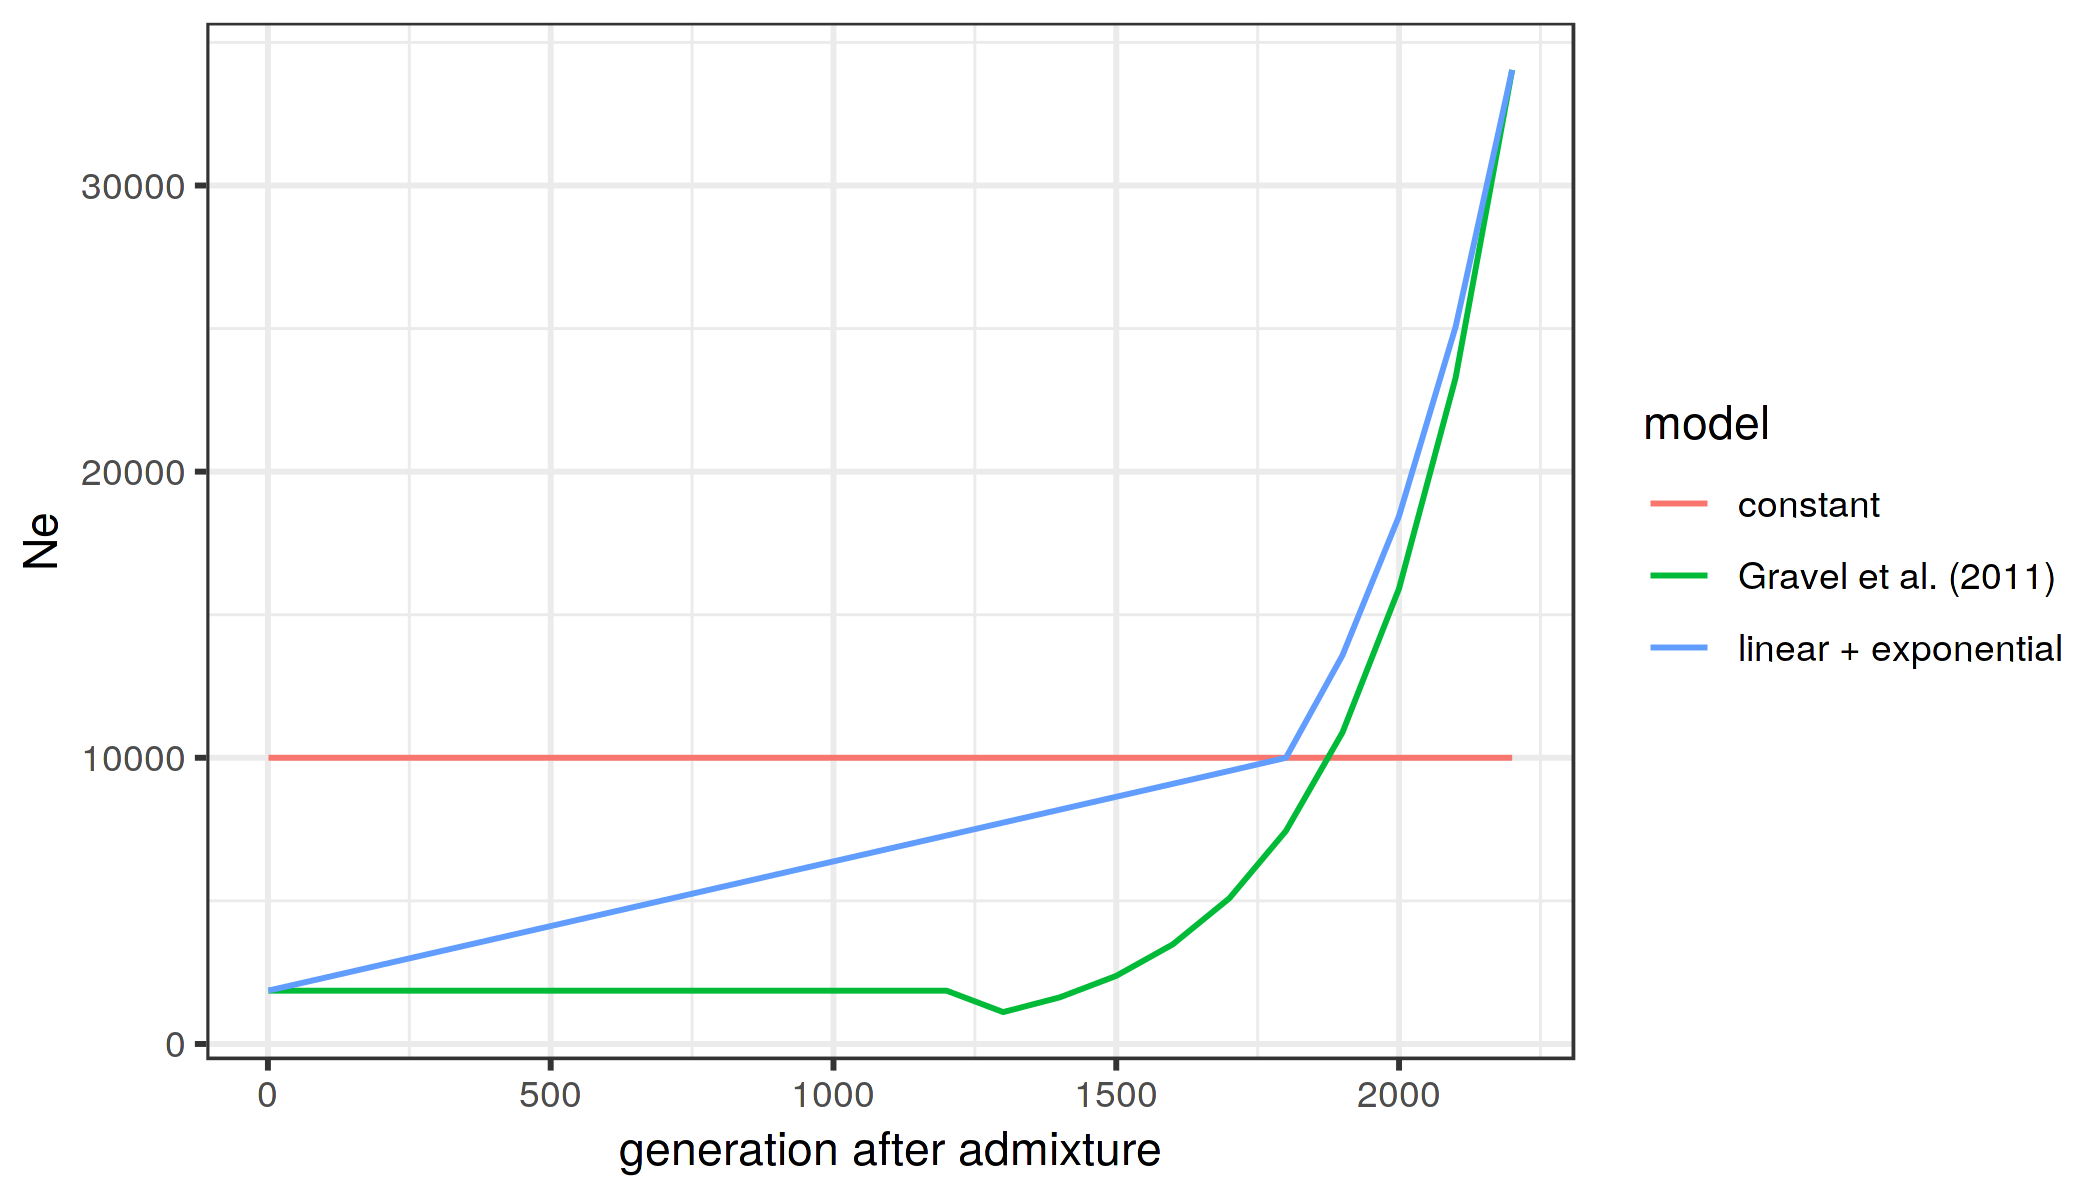

In [34]:
set_dim(7, 4, 300)

bind_rows(
    suppressMessages(read_tsv(here("data/simulations", "traj_constant_exon_rep_1_trajectory.txt"))) %>% mutate(model = "constant"),
    suppressMessages(read_tsv(here("data/simulations", "traj_linear_exon_rep_1_trajectory.txt"))) %>% mutate(model = "linear + exponential"),
    suppressMessages(read_tsv(here("data/simulations", "traj_gravel_exon_rep_1_trajectory.txt"))) %>% mutate(model = "Gravel et al. (2011)")
)  %>%
ggplot(aes(gen, Ne, color = model)) + geom_line() + xlab("generation after admixture") + theme_bw()

ggsave(here("figures/S14.png"), width = 7, height = 4, units = "in")

# Fig S15

In [35]:
lm_fun <- function(df) cor.test(as.numeric(df$dist_bin), df$nea_prop, method = "pearson")

In [36]:
model_props <- bin_props %>%
    filter(gen >= 5) %>% 
    group_by(gen, chr) %>%
    nest %>%
    mutate(model = map(data, lm_fun),
           stats = map(model, glance)) %>%
    unnest(stats, .drop = TRUE)

Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”

In [37]:
model_props %>%
    group_by(gen) %>%
    summarise(mean(estimate, na.rm = TRUE))

gen  mean(estimate, na.rm = TRUE)
1     5 0.06152396                  
2    10 0.07142704                  
3    20 0.11099259                  
4    50 0.29130737                  
5   100 0.41510625                  
6   200 0.57327901                  
7   400 0.78703475                  
8   600 0.84404801                  
9   800 0.89364790                  
10 1000 0.92179066                  
11 1200 0.92650539                  
12 1400 0.93870116                  
13 1600 0.94916468                  
14 1800 0.94951000                  
15 2000 0.95613878                  
16 2200 0.95984414

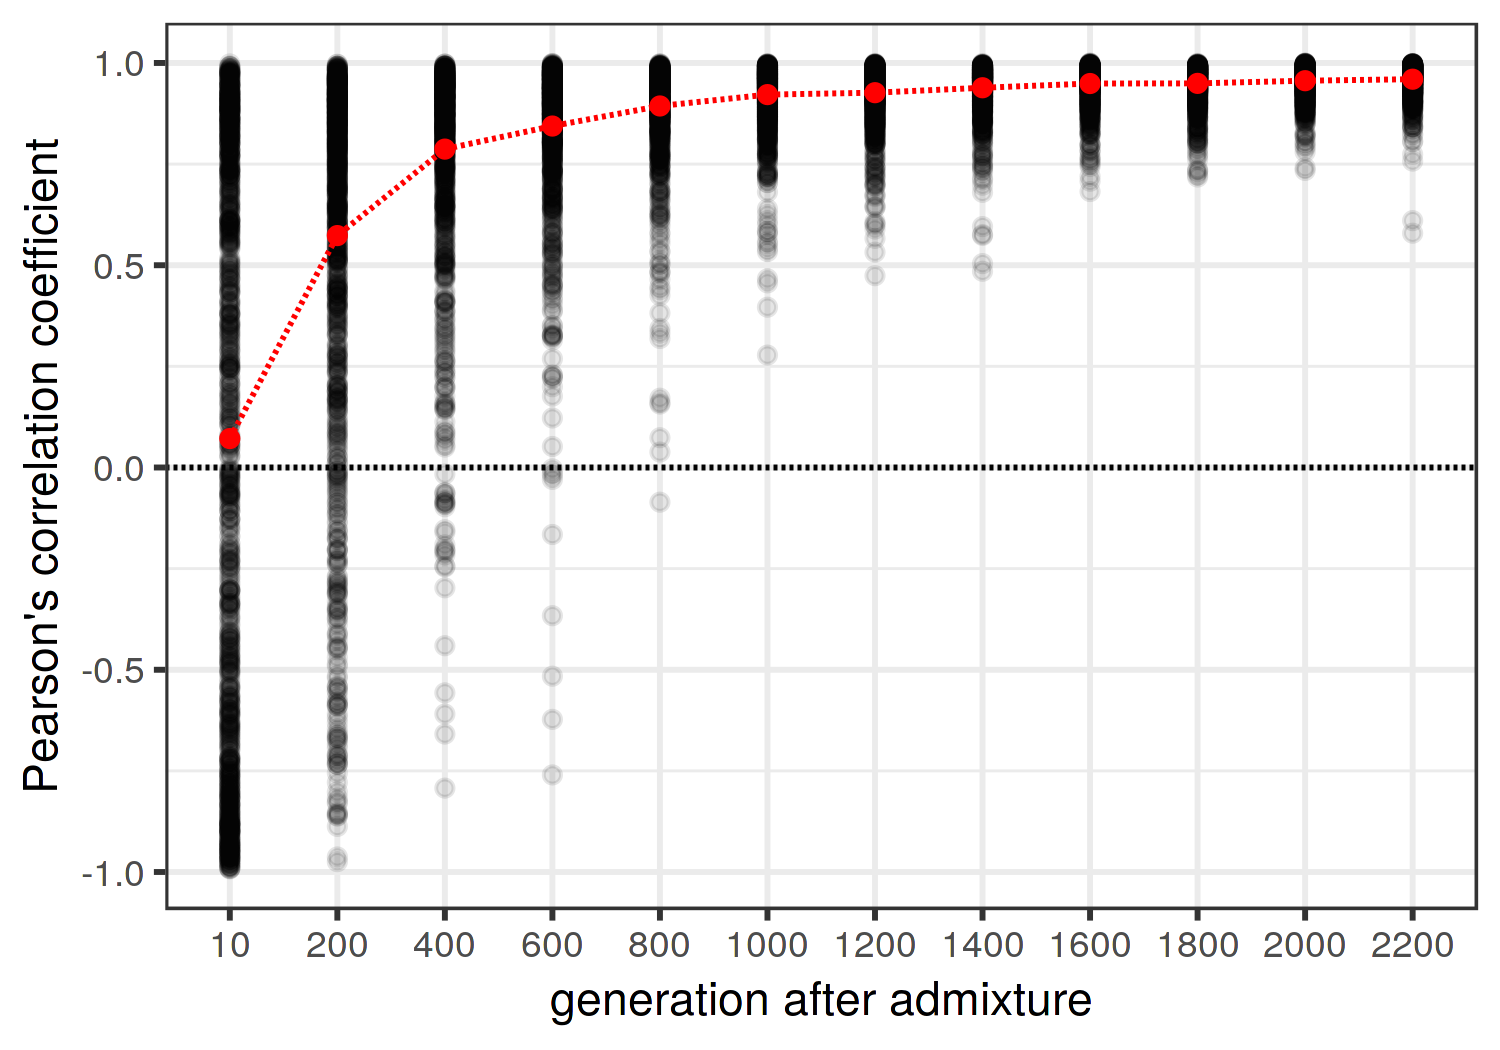

In [38]:
set_dim(5, 3.5, 300)

model_props %>% filter(gen == 10 | gen >= 200) %>% mutate(gen = factor(gen)) %>% {
    ggplot(., aes(gen, estimate)) +
        geom_point(alpha = 1/10) +
        geom_point(data = group_by(., gen) %>% summarise(mu = mean(estimate, na.rm = TRUE)), aes(gen, mu), color = "red") +
        geom_line(data = group_by(., gen) %>% summarise(mu = mean(estimate, na.rm = TRUE)), aes(gen, mu, group = 1), color = "red", linetype = 2) +
        geom_hline(yintercept = 0, linetype = 2, color = "black") +
        xlab("generation after admixture") +
        ylab("Pearson's correlation coefficient") +
        theme_bw()
}

ggsave(here("figures/S15.png"), width = 5, height = 3.5, units = "in")